In [1]:
from pathlib import Path
import pandas as pd
from src.hrv_epatch.rpeak.rr_compare import run_rr_comparison_from_df

LVM_ROOT = r"E:\Speciale - Results\Final-LabView-Trim-Testset"
EXTRA_DIR_ADD = "Trim"
# OUT_DIR = Path(r"E:\Speciale - Results\study3") / "Study3_RRCompare_metrics_Trim.csv"


# LVM_ROOT = r"E:\Speciale - Results\Final-LabView-Raw"
# EXTRA_DIR_ADD = "RAW"

df_rec = pd.read_parquet(r"E:\Speciale - Results\df_rec.parquet")

df_rec["lvm_file"] = df_rec["recording_uid"].apply(
    lambda uid: Path(LVM_ROOT) / f"{uid}.lvm"
    if (Path(LVM_ROOT) / f"{uid}.lvm").exists()
    else None
)

df_rec_with_lvm = df_rec[df_rec["lvm_file"].notnull()]


In [2]:
# df_rec[df_rec["patient_id"] == 8]
# patients = [2]
# df_index = df_rec_with_lvm[df_rec_with_lvm["patient_id"].isin(patients)].copy()
# df_index

# methods = ["neurokit", "pantompkins1985", "hamilton2002"]
# methods_extra = ["neurokit", "biosppy", "pantompkins1985", "hamilton2002", "elgendi2010", "engzeemod2012", 'vg']

In [ ]:
from pathlib import Path
from src.hrv_epatch.rpeak.rr_compare import run_rr_comparison_from_df

cache_dir = Path(r"E:\Speciale - Results\rpeak_cache") / EXTRA_DIR_ADD

df_metrics = run_rr_comparison_from_df(
    df_index=df_rec_with_lvm,
    methods=["neurokit","pantompkins1985", "hamilton2002", "emrich2023"],
    aligned_dir= Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_" + EXTRA_DIR_ADD),
    patient_filter=None,
    max_duration_s=None,
    rpeak_cache_dir=cache_dir,
    force_recompute=True,
    debug=False,
)

RR/peak comparison for:: 100%|██████████| 288/288 [3:30:18<00:00, 43.81s/it]  


In [ ]:

df_metrics = run_rr_comparison_from_df(
    df_index=df_rec_with_lvm,
    methods=["neurokit","pantompkins1985", "hamilton2002", "emrich2023"],
    aligned_dir= Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_" + EXTRA_DIR_ADD),
    patient_filter=None,
    max_duration_s=None,
    rpeak_cache_dir=cache_dir,
    force_recompute=True,
    debug=False,
)

In [4]:
out_csv = Path(Path(r"E:\Speciale - Results\study3") / ("Study3_RRCompare_metrics_" + EXTRA_DIR_ADD + ".csv"))
out_csv.parent.mkdir(parents=True, exist_ok=True)
df_metrics.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Saved: E:\Speciale - Results\study3\Study3_RRCompare_metrics_Trim.csv


In [5]:
must_cols = [
    "patient_id","recording_id","algo_id",
    "rr_mae_ms","rr_corr","peak_f1",
    "n_peaks_tp","n_peaks_fp","n_peaks_fn",
]
missing = [c for c in must_cols if c not in df_metrics.columns]
print("Missing:", missing)

extra = ["median_dt_ms","p95_abs_dt_ms","offset0_s","best_delta_s"]
print("Has dt cols:", [c for c in extra if c in df_metrics.columns])

Missing: []
Has dt cols: ['median_dt_ms', 'p95_abs_dt_ms', 'offset0_s', 'best_delta_s']


In [6]:
import numpy as np
import pandas as pd

def q25(x): return np.nanpercentile(x, 25)
def q50(x): return np.nanpercentile(x, 50)
def q75(x): return np.nanpercentile(x, 75)

agg = {
    "rr_mae_ms": [q50, q25, q75, "mean"],
    "rr_corr":   [q50, q25, q75, "mean"],
    "peak_f1":   [q50, q25, q75, "mean"],
    "n_peaks_fp": ["sum", q50],
    "n_peaks_fn": ["sum", q50],
}

# hvis du har dem
if "median_dt_ms" in df_metrics.columns:
    agg["median_dt_ms"] = [q50, q25, q75, "mean"]
if "p95_abs_dt_ms" in df_metrics.columns:
    agg["p95_abs_dt_ms"] = [q50, q25, q75, "mean"]

df_method_summary = (
    df_metrics
    .groupby("algo_id", dropna=False)
    .agg(agg)
)

# pænere kolonnenavne
df_method_summary.columns = ["_".join([c for c in col if c]) for col in df_method_summary.columns.to_flat_index()]
df_method_summary = df_method_summary.sort_values("peak_f1_q50", ascending=False)

display(df_method_summary)


,rr_mae_ms_q50,rr_mae_ms_q25,rr_mae_ms_q75,rr_mae_ms_mean,rr_corr_q50,rr_corr_q25,rr_corr_q75,rr_corr_mean,peak_f1_q50,peak_f1_q25,...,n_peaks_fn_sum,n_peaks_fn_q50,median_dt_ms_q50,median_dt_ms_q25,median_dt_ms_q75,median_dt_ms_mean,p95_abs_dt_ms_q50,p95_abs_dt_ms_q25,p95_abs_dt_ms_q75,p95_abs_dt_ms_mean
algo_id,,,,,,,,,,,,,,,,,,,,,
emrich2023,2.149779,1.567521,3.737790,6.025580,0.994018,0.914927,0.998519,0.824014,0.998723,0.995107,...,263140,234.0,-0.000954,-0.002682,-0.000238,-0.005108,3.359318,2.801323,4.721016,4.219954
neurokit,2.896542,1.673470,5.765214,5.292475,0.975308,0.847053,0.994734,0.867361,0.997398,0.993199,...,123519,382.0,-0.000477,-0.002593,0.000000,-0.003331,2.748728,2.521396,3.532535,3.495140
hamilton2002,10.715140,5.895144,29.526490,35.284711,0.718467,0.098137,0.988348,0.565099,0.983747,0.849403,...,2439070,3914.5,0.000000,0.000000,0.000238,-0.251104,24.930435,19.128540,35.119507,24.676050
pantompkins1985,31.282377,22.477534,86.486745,231.311431,0.340012,0.006190,0.952755,0.435419,0.584252,0.316669,...,7445330,86855.0,1.088858,0.319660,1.948953,1.643032,32.152027,7.544544,37.020457,25.015479


In [7]:
sum_csv = Path(Path(r"E:\Speciale - Results\study3") / ("Study3_RRCompare_summary_by_method_" + EXTRA_DIR_ADD + ".csv"))
df_method_summary.to_csv(sum_csv)
print("Saved:", sum_csv)


Saved: E:\Speciale - Results\study3\Study3_RRCompare_summary_by_method_Trim.csv


In [8]:
df = df_metrics.copy()

df["n_mismatch"] = df["n_peaks_fp"].fillna(0).astype(int) + df["n_peaks_fn"].fillna(0).astype(int)

# thresholds (tune efter behov)
F1_TH   = 0.995
MIS_TH  = 200
P95_TH  = 20.0   # ms

conds = (df["peak_f1"] < F1_TH) | (df["n_mismatch"] > MIS_TH)

if "p95_abs_dt_ms" in df.columns:
    conds = conds | (df["p95_abs_dt_ms"] > P95_TH)

df_audit = (
    df.loc[conds, [
        "patient_id","recording_id","algo_id",
        "peak_f1","rr_mae_ms","rr_corr",
        "n_peaks_tp","n_peaks_fp","n_peaks_fn","n_mismatch",
        *([ "median_dt_ms","p95_abs_dt_ms" ] if "p95_abs_dt_ms" in df.columns else []),
        "best_delta_s","offset0_s",
        "raw_tdms_path","raw_lvm_path",
    ]]
    .sort_values(["algo_id","peak_f1","n_mismatch"], ascending=[True, True, False])
)

display(df_audit.head(50))
print("Audit candidates:", len(df_audit))


,patient_id,recording_id,algo_id,peak_f1,rr_mae_ms,rr_corr,n_peaks_tp,n_peaks_fp,n_peaks_fn,n_mismatch,median_dt_ms,p95_abs_dt_ms,best_delta_s,offset0_s,raw_tdms_path,raw_lvm_path
279,41,1,emrich2023,0.873518,41.136273,0.104774,253736,2061,71419,73480,-0.006437,2.876997,0.067704,567.351790,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
251,36,2,emrich2023,0.883369,33.148440,0.531297,77456,2200,18253,20453,-0.048637,7.304668,0.068606,237.894041,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
247,36,1,emrich2023,0.901917,49.781335,0.186709,212534,8395,37831,46226,-0.044107,5.076814,0.070032,2718.409566,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
119,18,1,emrich2023,0.925501,22.531431,0.536871,183705,13073,16502,29575,-0.108957,13.892126,0.070470,217.439732,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
103,15,1,emrich2023,0.930021,24.343805,0.007316,194260,4452,24782,29234,-0.020027,3.781319,0.069001,47.131854,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
151,23,1,emrich2023,0.936837,29.918054,0.088794,170560,527,22472,22999,-0.000715,2.789736,0.068390,217.499800,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
143,22,1,emrich2023,0.959435,22.045385,-0.002773,209437,1899,15811,17710,-0.007868,4.437923,0.071203,277.157074,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
139,21,2,emrich2023,0.965930,18.145702,-0.047553,177723,2172,10365,12537,-0.019073,4.639149,0.067246,267.469603,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
135,21,1,emrich2023,0.973448,22.479259,0.046486,182390,1586,8364,9950,-0.014663,5.015850,0.066938,257.835293,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...
179,26,1,emrich2023,0.985431,15.085970,0.366532,176059,3396,1810,5206,-0.012159,5.851293,0.070567,127.301867,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...


Audit candidates: 245


In [9]:
audit_csv = Path(Path(r"E:\Speciale - Results\study3") / ("Study3_RRCompare_audit_candidates_" + EXTRA_DIR_ADD + ".csv"))
df_audit.to_csv(audit_csv, index=False)
print("Saved:", audit_csv)


Saved: E:\Speciale - Results\study3\Study3_RRCompare_audit_candidates_Trim.csv


In [10]:
df_rec_summary = (
    df_metrics.assign(n_mismatch=lambda d: d["n_peaks_fp"].fillna(0) + d["n_peaks_fn"].fillna(0))
    .groupby(["patient_id","recording_id"], dropna=False)
    .agg(
        n_algos=("algo_id","count"),
        worst_f1=("peak_f1","min"),
        median_f1=("peak_f1","median"),
        worst_mismatch=("n_mismatch","max"),
        median_rr_mae=("rr_mae_ms","median"),
        median_rr_corr=("rr_corr","median"),
    )
    .sort_values(["worst_f1","worst_mismatch"], ascending=[True, False])
)
display(df_rec_summary.head(50))


,,n_algos,worst_f1,median_f1,worst_mismatch,median_rr_mae,median_rr_corr
patient_id,recording_id,,,,,,
32,1,4,0.000046,0.927708,172122,4.009262,0.969696
27,1,8,0.006200,0.923846,239801,20.732987,0.543439
21,1,4,0.011817,0.499242,166079,81.978752,0.147658
29,1,4,0.012007,0.961653,345256,17.857823,0.128488
15,1,4,0.028847,0.635908,193174,45.633854,-0.017088
12,1,4,0.031831,0.881779,210720,21.312456,0.475871
36,2,4,0.054687,0.578584,92860,343.157614,0.233237
26,1,4,0.092599,0.732958,167725,83.197806,0.183024
41,1,4,0.095043,0.709053,315429,104.336341,0.068184


In [11]:
rec_csv = Path(Path(r"E:\Speciale - Results\study3") / ("Study3_RRCompare_summary_by_recording_" + EXTRA_DIR_ADD + ".csv"))
df_rec_summary.to_csv(rec_csv)
print("Saved:", rec_csv)


Saved: E:\Speciale - Results\study3\Study3_RRCompare_summary_by_recording_Trim.csv


In [12]:
# vælg fx 5 værste pr. metode
df_pick = (
    df_audit
    .groupby("algo_id", group_keys=False)
    .head(5)
)

pairs = set(zip(df_pick["patient_id"], df_pick["recording_id"]))
df_sub = df_rec_with_lvm[df_rec_with_lvm.apply(lambda r: (r["patient_id"], r["recording_id"]) in pairs, axis=1)].copy()

df_metrics_audit = run_rr_comparison_from_df(
    df_index=df_sub,
    methods=df_pick["algo_id"].unique().tolist(),
    aligned_dir=Path(r"E:\Speciale - Results\Final_RR_alignment\Audit_rerun_" + EXTRA_DIR_ADD),
    patient_filter=None,
    max_duration_s=None,
    rpeak_cache_dir=Path(r"E:\Speciale - Results\rpeak_cache"),
    force_recompute=False,
    debug=True,   # <-- så audit/plots aktiveres i din process_recording
)


RR/peak comparison for::   0%|          | 0/52 [00:00<?, ?it/s]

[DEBUG] TDMS start dt   : 2017-06-15 14:19:43 (epoch=1497529183.000000)
[DEBUG] LVM  header dt : 2017-06-15 14:21:40.224722 (epoch=1497529300.224722)
[DEBUG] offset0_s (LVM header - TDMS start): 117.224722 s
[DEBUG] LVM window start/end (rel. TDMS): 117.225s  -> 61041.235s
[DEBUG] TDMS crop idx start/end: 60019 -> 31253112  (len(ecg_full)=31355776)
[DEBUG] #py_peaks full=78095  cropped=78095  #lv_peaks=84024
[DEBUG] Python peaks crop epoch: 1497529300.445 -> 1497590541.754
[DEBUG] LabVIEW  peaks        : 1497529300.225 -> 1497590224.235
[DEBUG] Crop epoch start/end : 1497529300.225 -> 1497590224.234
[DEBUG] best_delta_s (py->lv): -0.002334
[DEBUG] delta_lv_s  (lv->py): 0.002334
[DEBUG] overlap_start/end epoch: 1497529300.445 -> 1497590224.235
[DEBUG] matched peaks: 8676
[DEBUG] median |dt| (ms): 19.833
[DEBUG] p95 |dt| (ms): 37.860


RR/peak comparison for::   2%|▏         | 1/52 [00:05<04:49,  5.67s/it]

[DEBUG] TDMS start dt   : 2017-06-15 14:19:43 (epoch=1497529183.000000)
[DEBUG] LVM  header dt : 2017-06-15 14:21:40.224722 (epoch=1497529300.224722)
[DEBUG] offset0_s (LVM header - TDMS start): 117.224722 s
[DEBUG] LVM window start/end (rel. TDMS): 117.225s  -> 61041.235s
[DEBUG] TDMS crop idx start/end: 60019 -> 31253112  (len(ecg_full)=31355776)
[DEBUG] #py_peaks full=41128  cropped=41128  #lv_peaks=84024
[DEBUG] Python peaks crop epoch: 1497529300.529 -> 1497590541.791
[DEBUG] LabVIEW  peaks        : 1497529300.225 -> 1497590224.235
[DEBUG] Crop epoch start/end : 1497529300.225 -> 1497590224.234
[DEBUG] Hamilton refine: median_dt=0.508 ms (p95|dt|=37.933 ms) delta_lv 0.003703 -> 0.004212
[DEBUG] best_delta_s (py->lv): -0.003703
[DEBUG] delta_lv_s  (lv->py): 0.004212
[DEBUG] overlap_start/end epoch: 1497529300.529 -> 1497590224.235
[DEBUG] matched peaks: 4811
[DEBUG] median |dt| (ms): 20.235
[DEBUG] p95 |dt| (ms): 37.823


RR/peak comparison for::   4%|▍         | 2/52 [00:10<04:31,  5.43s/it]

[DEBUG] TDMS start dt   : 2017-06-15 14:19:43 (epoch=1497529183.000000)
[DEBUG] LVM  header dt : 2017-06-15 14:21:40.224722 (epoch=1497529300.224722)
[DEBUG] offset0_s (LVM header - TDMS start): 117.224722 s
[DEBUG] LVM window start/end (rel. TDMS): 117.225s  -> 61041.235s
[DEBUG] TDMS crop idx start/end: 60019 -> 31253112  (len(ecg_full)=31355776)
[DEBUG] #py_peaks full=78620  cropped=78620  #lv_peaks=84024
[DEBUG] Python peaks crop epoch: 1497529301.217 -> 1497590541.754
[DEBUG] LabVIEW  peaks        : 1497529300.225 -> 1497590224.235
[DEBUG] Crop epoch start/end : 1497529300.225 -> 1497590224.234
[DEBUG] best_delta_s (py->lv): -0.002237
[DEBUG] delta_lv_s  (lv->py): 0.002237
[DEBUG] overlap_start/end epoch: 1497529301.217 -> 1497590224.235
[DEBUG] matched peaks: 8778
[DEBUG] median |dt| (ms): 19.934
[DEBUG] p95 |dt| (ms): 37.922


RR/peak comparison for::   6%|▌         | 3/52 [00:16<04:35,  5.63s/it]

[DEBUG] TDMS start dt   : 2017-06-15 14:19:43 (epoch=1497529183.000000)
[DEBUG] LVM  header dt : 2017-06-15 14:21:40.224722 (epoch=1497529300.224722)
[DEBUG] offset0_s (LVM header - TDMS start): 117.224722 s
[DEBUG] LVM window start/end (rel. TDMS): 117.225s  -> 61041.235s
[DEBUG] TDMS crop idx start/end: 60019 -> 31253112  (len(ecg_full)=31355776)
[DEBUG] #py_peaks full=41143  cropped=41143  #lv_peaks=84024
[DEBUG] Python peaks crop epoch: 1497529300.529 -> 1497590541.834
[DEBUG] LabVIEW  peaks        : 1497529300.225 -> 1497590224.235
[DEBUG] Crop epoch start/end : 1497529300.225 -> 1497590224.234
[DEBUG] best_delta_s (py->lv): -0.004631
[DEBUG] delta_lv_s  (lv->py): 0.004631
[DEBUG] overlap_start/end epoch: 1497529300.529 -> 1497590224.235
[DEBUG] matched peaks: 4771
[DEBUG] median |dt| (ms): 19.944
[DEBUG] p95 |dt| (ms): 37.687


RR/peak comparison for::   8%|▊         | 4/52 [00:21<04:21,  5.44s/it]

[DEBUG] TDMS start dt   : 2017-10-02 13:36:06 (epoch=1506944166.000000)
[DEBUG] LVM  header dt : 2017-10-02 13:37:18.113148 (epoch=1506944238.113148)
[DEBUG] offset0_s (LVM header - TDMS start): 72.113148 s
[DEBUG] LVM window start/end (rel. TDMS): 72.113s  -> 172697.815s
[DEBUG] TDMS crop idx start/end: 36922 -> 88421281  (len(ecg_full)=88434944)
[DEBUG] #py_peaks full=189214  cropped=189214  #lv_peaks=210615
[DEBUG] Python peaks crop epoch: 1506944238.305 -> 1507116962.461
[DEBUG] LabVIEW  peaks        : 1506944238.113 -> 1507116863.815
[DEBUG] Crop epoch start/end : 1506944238.113 -> 1507116863.814
[DEBUG] best_delta_s (py->lv): 0.000778
[DEBUG] delta_lv_s  (lv->py): -0.000778
[DEBUG] overlap_start/end epoch: 1506944238.305 -> 1507116863.815
[DEBUG] matched peaks: 18648
[DEBUG] median |dt| (ms): 20.036
[DEBUG] p95 |dt| (ms): 37.981


RR/peak comparison for::  10%|▉         | 5/52 [00:32<05:40,  7.24s/it]

[DEBUG] TDMS start dt   : 2017-10-02 13:36:06 (epoch=1506944166.000000)
[DEBUG] LVM  header dt : 2017-10-02 13:37:18.113148 (epoch=1506944238.113148)
[DEBUG] offset0_s (LVM header - TDMS start): 72.113148 s
[DEBUG] LVM window start/end (rel. TDMS): 72.113s  -> 172697.815s
[DEBUG] TDMS crop idx start/end: 36922 -> 88421281  (len(ecg_full)=88434944)
[DEBUG] #py_peaks full=16  cropped=16  #lv_peaks=210615
[DEBUG] Python peaks crop epoch: 1506944238.418 -> 1507116962.506
[DEBUG] LabVIEW  peaks        : 1506944238.113 -> 1507116863.815
[DEBUG] Crop epoch start/end : 1506944238.113 -> 1507116863.814
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv -0.510120 -> -0.510120
[DEBUG] best_delta_s (py->lv): 0.510120
[DEBUG] delta_lv_s  (lv->py): -0.510120
[DEBUG] overlap_start/end epoch: 1506944238.418 -> 1507116863.815
[DEBUG] matched peaks: 0


RR/peak comparison for::  12%|█▏        | 6/52 [00:34<04:18,  5.62s/it]

[DEBUG] TDMS start dt   : 2017-10-02 13:36:06 (epoch=1506944166.000000)
[DEBUG] LVM  header dt : 2017-10-02 13:37:18.113148 (epoch=1506944238.113148)
[DEBUG] offset0_s (LVM header - TDMS start): 72.113148 s
[DEBUG] LVM window start/end (rel. TDMS): 72.113s  -> 172697.815s
[DEBUG] TDMS crop idx start/end: 36922 -> 88421281  (len(ecg_full)=88434944)
[DEBUG] #py_peaks full=210098  cropped=210098  #lv_peaks=210615
[DEBUG] Python peaks crop epoch: 1506944239.900 -> 1507116962.482
[DEBUG] LabVIEW  peaks        : 1506944238.113 -> 1507116863.815
[DEBUG] Crop epoch start/end : 1506944238.113 -> 1507116863.814
[DEBUG] best_delta_s (py->lv): -0.000464
[DEBUG] delta_lv_s  (lv->py): 0.000464
[DEBUG] overlap_start/end epoch: 1506944239.900 -> 1507116863.815
[DEBUG] matched peaks: 20996
[DEBUG] median |dt| (ms): 20.129
[DEBUG] p95 |dt| (ms): 38.062


RR/peak comparison for::  13%|█▎        | 7/52 [00:45<05:30,  7.35s/it]

[DEBUG] TDMS start dt   : 2017-10-02 13:36:06 (epoch=1506944166.000000)
[DEBUG] LVM  header dt : 2017-10-02 13:37:18.113148 (epoch=1506944238.113148)
[DEBUG] offset0_s (LVM header - TDMS start): 72.113148 s
[DEBUG] LVM window start/end (rel. TDMS): 72.113s  -> 172697.815s
[DEBUG] TDMS crop idx start/end: 36922 -> 88421281  (len(ecg_full)=88434944)
[DEBUG] #py_peaks full=34  cropped=34  #lv_peaks=210615
[DEBUG] Python peaks crop epoch: 1506944238.424 -> 1507116962.539
[DEBUG] LabVIEW  peaks        : 1506944238.113 -> 1507116863.815
[DEBUG] Crop epoch start/end : 1506944238.113 -> 1507116863.814
[DEBUG] best_delta_s (py->lv): 0.108881
[DEBUG] delta_lv_s  (lv->py): -0.108881
[DEBUG] overlap_start/end epoch: 1506944238.424 -> 1507116863.815
[DEBUG] matched peaks: 2
[DEBUG] median |dt| (ms): 11.762
[DEBUG] p95 |dt| (ms): 22.348


RR/peak comparison for::  15%|█▌        | 8/52 [00:49<04:33,  6.21s/it]

[DEBUG] TDMS start dt   : 2017-10-30 14:01:40 (epoch=1509368500.000000)
[DEBUG] LVM  header dt : 2017-10-30 14:02:47.319388 (epoch=1509368567.319388)
[DEBUG] offset0_s (LVM header - TDMS start): 67.319388 s
[DEBUG] LVM window start/end (rel. TDMS): 67.319s  -> 178786.462s
[DEBUG] TDMS crop idx start/end: 34468 -> 91538668  (len(ecg_full)=91565184)
[DEBUG] #py_peaks full=118943  cropped=118943  #lv_peaks=231855
[DEBUG] Python peaks crop epoch: 1509368568.229 -> 1509547405.129
[DEBUG] LabVIEW  peaks        : 1509368567.319 -> 1509547286.462
[DEBUG] Crop epoch start/end : 1509368567.320 -> 1509547286.461
[DEBUG] best_delta_s (py->lv): -0.007361
[DEBUG] delta_lv_s  (lv->py): 0.007361
[DEBUG] overlap_start/end epoch: 1509368568.229 -> 1509547286.462
[DEBUG] matched peaks: 12156
[DEBUG] median |dt| (ms): 19.968
[DEBUG] p95 |dt| (ms): 37.860


RR/peak comparison for::  17%|█▋        | 9/52 [01:00<05:26,  7.59s/it]

[DEBUG] TDMS start dt   : 2017-10-30 14:01:40 (epoch=1509368500.000000)
[DEBUG] LVM  header dt : 2017-10-30 14:02:47.319388 (epoch=1509368567.319388)
[DEBUG] offset0_s (LVM header - TDMS start): 67.319388 s
[DEBUG] LVM window start/end (rel. TDMS): 67.319s  -> 178786.462s
[DEBUG] TDMS crop idx start/end: 34468 -> 91538668  (len(ecg_full)=91565184)
[DEBUG] #py_peaks full=38  cropped=38  #lv_peaks=231855
[DEBUG] Python peaks crop epoch: 1509368567.656 -> 1509547403.861
[DEBUG] LabVIEW  peaks        : 1509368567.319 -> 1509547286.462
[DEBUG] Crop epoch start/end : 1509368567.320 -> 1509547286.461
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv -0.044874 -> -0.044874
[DEBUG] best_delta_s (py->lv): 0.044874
[DEBUG] delta_lv_s  (lv->py): -0.044874
[DEBUG] overlap_start/end epoch: 1509368567.656 -> 1509547286.462
[DEBUG] matched peaks: 2
[DEBUG] median |dt| (ms): 0.804
[DEBUG] p95 |dt| (ms): 0.804


RR/peak comparison for::  19%|█▉        | 10/52 [01:05<04:43,  6.74s/it]

[DEBUG] TDMS start dt   : 2017-10-30 14:01:40 (epoch=1509368500.000000)
[DEBUG] LVM  header dt : 2017-10-30 14:02:47.319388 (epoch=1509368567.319388)
[DEBUG] offset0_s (LVM header - TDMS start): 67.319388 s
[DEBUG] LVM window start/end (rel. TDMS): 67.319s  -> 178786.462s
[DEBUG] TDMS crop idx start/end: 34468 -> 91538668  (len(ecg_full)=91565184)
[DEBUG] #py_peaks full=231807  cropped=231807  #lv_peaks=231855
[DEBUG] Python peaks crop epoch: 1509368570.961 -> 1509547405.133
[DEBUG] LabVIEW  peaks        : 1509368567.319 -> 1509547286.462
[DEBUG] Crop epoch start/end : 1509368567.320 -> 1509547286.461
[DEBUG] best_delta_s (py->lv): -0.002632
[DEBUG] delta_lv_s  (lv->py): 0.002632
[DEBUG] overlap_start/end epoch: 1509368570.961 -> 1509547286.462
[DEBUG] matched peaks: 24083
[DEBUG] median |dt| (ms): 20.079
[DEBUG] p95 |dt| (ms): 38.010


RR/peak comparison for::  21%|██        | 11/52 [01:17<05:44,  8.40s/it]

[DEBUG] TDMS start dt   : 2017-10-30 14:01:40 (epoch=1509368500.000000)
[DEBUG] LVM  header dt : 2017-10-30 14:02:47.319388 (epoch=1509368567.319388)
[DEBUG] offset0_s (LVM header - TDMS start): 67.319388 s
[DEBUG] LVM window start/end (rel. TDMS): 67.319s  -> 178786.462s
[DEBUG] TDMS crop idx start/end: 34468 -> 91538668  (len(ecg_full)=91565184)
[DEBUG] #py_peaks full=33  cropped=33  #lv_peaks=231855
[DEBUG] Python peaks crop epoch: 1509368567.637 -> 1509547403.865
[DEBUG] LabVIEW  peaks        : 1509368567.319 -> 1509547286.462
[DEBUG] Crop epoch start/end : 1509368567.320 -> 1509547286.461
[DEBUG] best_delta_s (py->lv): 0.042675
[DEBUG] delta_lv_s  (lv->py): -0.042675
[DEBUG] overlap_start/end epoch: 1509368567.637 -> 1509547286.462
[DEBUG] matched peaks: 2
[DEBUG] median |dt| (ms): 32.645
[DEBUG] p95 |dt| (ms): 32.645


RR/peak comparison for::  23%|██▎       | 12/52 [01:21<04:51,  7.29s/it]

[DEBUG] TDMS start dt   : 2017-11-27 12:11:09 (epoch=1511781069.000000)
[DEBUG] LVM  header dt : 2017-11-27 12:11:56.131854 (epoch=1511781116.131854)
[DEBUG] offset0_s (LVM header - TDMS start): 47.131854 s
[DEBUG] LVM window start/end (rel. TDMS): 47.132s  -> 179118.601s
[DEBUG] TDMS crop idx start/end: 24132 -> 91708724  (len(ecg_full)=91739776)
[DEBUG] #py_peaks full=198818  cropped=198818  #lv_peaks=219044
[DEBUG] Python peaks crop epoch: 1511781116.172 -> 1511960295.076
[DEBUG] LabVIEW  peaks        : 1511781116.132 -> 1511960187.601
[DEBUG] Crop epoch start/end : 1511781116.133 -> 1511960187.602
[DEBUG] best_delta_s (py->lv): 0.004381
[DEBUG] delta_lv_s  (lv->py): -0.004381
[DEBUG] overlap_start/end epoch: 1511781116.172 -> 1511960187.601
[DEBUG] matched peaks: 20122
[DEBUG] median |dt| (ms): 19.958
[DEBUG] p95 |dt| (ms): 37.999


RR/peak comparison for::  25%|██▌       | 13/52 [01:33<05:30,  8.49s/it]

[DEBUG] TDMS start dt   : 2017-11-27 12:11:09 (epoch=1511781069.000000)
[DEBUG] LVM  header dt : 2017-11-27 12:11:56.131854 (epoch=1511781116.131854)
[DEBUG] offset0_s (LVM header - TDMS start): 47.131854 s
[DEBUG] LVM window start/end (rel. TDMS): 47.132s  -> 179118.601s
[DEBUG] TDMS crop idx start/end: 24132 -> 91708724  (len(ecg_full)=91739776)
[DEBUG] #py_peaks full=54158  cropped=54158  #lv_peaks=219044
[DEBUG] Python peaks crop epoch: 1511781116.441 -> 1511960294.951
[DEBUG] LabVIEW  peaks        : 1511781116.132 -> 1511960187.601
[DEBUG] Crop epoch start/end : 1511781116.133 -> 1511960187.602
[DEBUG] Hamilton refine: median_dt=0.386 ms (p95|dt|=37.995 ms) delta_lv 0.006468 -> 0.006854
[DEBUG] best_delta_s (py->lv): -0.006468
[DEBUG] delta_lv_s  (lv->py): 0.006854
[DEBUG] overlap_start/end epoch: 1511781116.441 -> 1511960187.601
[DEBUG] matched peaks: 5854
[DEBUG] median |dt| (ms): 19.659
[DEBUG] p95 |dt| (ms): 38.052


RR/peak comparison for::  27%|██▋       | 14/52 [01:42<05:34,  8.81s/it]

[DEBUG] TDMS start dt   : 2017-11-27 12:11:09 (epoch=1511781069.000000)
[DEBUG] LVM  header dt : 2017-11-27 12:11:56.131854 (epoch=1511781116.131854)
[DEBUG] offset0_s (LVM header - TDMS start): 47.131854 s
[DEBUG] LVM window start/end (rel. TDMS): 47.132s  -> 179118.601s
[DEBUG] TDMS crop idx start/end: 24132 -> 91708724  (len(ecg_full)=91739776)
[DEBUG] #py_peaks full=213143  cropped=213143  #lv_peaks=219044
[DEBUG] Python peaks crop epoch: 1511781116.988 -> 1511960294.889
[DEBUG] LabVIEW  peaks        : 1511781116.132 -> 1511960187.601
[DEBUG] Crop epoch start/end : 1511781116.133 -> 1511960187.602
[DEBUG] best_delta_s (py->lv): 0.004295
[DEBUG] delta_lv_s  (lv->py): -0.004295
[DEBUG] overlap_start/end epoch: 1511781116.988 -> 1511960187.601
[DEBUG] matched peaks: 21254
[DEBUG] median |dt| (ms): 19.956
[DEBUG] p95 |dt| (ms): 38.052


RR/peak comparison for::  29%|██▉       | 15/52 [01:54<05:55,  9.61s/it]

[DEBUG] TDMS start dt   : 2017-11-27 12:11:09 (epoch=1511781069.000000)
[DEBUG] LVM  header dt : 2017-11-27 12:11:56.131854 (epoch=1511781116.131854)
[DEBUG] offset0_s (LVM header - TDMS start): 47.131854 s
[DEBUG] LVM window start/end (rel. TDMS): 47.132s  -> 179118.601s
[DEBUG] TDMS crop idx start/end: 24132 -> 91708724  (len(ecg_full)=91739776)
[DEBUG] #py_peaks full=123  cropped=123  #lv_peaks=219044
[DEBUG] Python peaks crop epoch: 1511781116.459 -> 1511960294.984
[DEBUG] LabVIEW  peaks        : 1511781116.132 -> 1511960187.601
[DEBUG] Crop epoch start/end : 1511781116.133 -> 1511960187.602
[DEBUG] best_delta_s (py->lv): -0.042935
[DEBUG] delta_lv_s  (lv->py): 0.042935
[DEBUG] overlap_start/end epoch: 1511781116.459 -> 1511960187.601
[DEBUG] matched peaks: 7
[DEBUG] median |dt| (ms): 21.647
[DEBUG] p95 |dt| (ms): 35.335


RR/peak comparison for::  31%|███       | 16/52 [02:01<05:24,  9.01s/it]

[DEBUG] TDMS start dt   : 2016-10-03 11:45:47 (epoch=1475487947.000000)
[DEBUG] LVM  header dt : 2016-10-03 11:49:24.439732 (epoch=1475488164.439732)
[DEBUG] offset0_s (LVM header - TDMS start): 217.439732 s
[DEBUG] LVM window start/end (rel. TDMS): 217.440s  -> 164128.718s
[DEBUG] TDMS crop idx start/end: 111329 -> 84033903  (len(ecg_full)=84137344)
[DEBUG] #py_peaks full=180143  cropped=180143  #lv_peaks=200209
[DEBUG] Python peaks crop epoch: 1475488164.473 -> 1475652494.924
[DEBUG] LabVIEW  peaks        : 1475488164.440 -> 1475652075.718
[DEBUG] Crop epoch start/end : 1475488164.439 -> 1475652075.717
[DEBUG] best_delta_s (py->lv): 0.001922
[DEBUG] delta_lv_s  (lv->py): -0.001922
[DEBUG] overlap_start/end epoch: 1475488164.473 -> 1475652075.718
[DEBUG] matched peaks: 18416
[DEBUG] median |dt| (ms): 19.933
[DEBUG] p95 |dt| (ms): 37.971


RR/peak comparison for::  33%|███▎      | 17/52 [02:12<05:30,  9.45s/it]

[DEBUG] TDMS start dt   : 2016-10-03 11:45:47 (epoch=1475487947.000000)
[DEBUG] LVM  header dt : 2016-10-03 11:49:24.439732 (epoch=1475488164.439732)
[DEBUG] offset0_s (LVM header - TDMS start): 217.439732 s
[DEBUG] LVM window start/end (rel. TDMS): 217.440s  -> 164128.718s
[DEBUG] TDMS crop idx start/end: 111329 -> 84033903  (len(ecg_full)=84137344)
[DEBUG] #py_peaks full=60  cropped=60  #lv_peaks=200209
[DEBUG] Python peaks crop epoch: 1475488164.777 -> 1475652495.018
[DEBUG] LabVIEW  peaks        : 1475488164.440 -> 1475652075.718
[DEBUG] Crop epoch start/end : 1475488164.439 -> 1475652075.717
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv 0.011711 -> 0.011711
[DEBUG] best_delta_s (py->lv): -0.011711
[DEBUG] delta_lv_s  (lv->py): 0.011711
[DEBUG] overlap_start/end epoch: 1475488164.777 -> 1475652075.718
[DEBUG] matched peaks: 2
[DEBUG] median |dt| (ms): 15.878
[DEBUG] p95 |dt| (ms): 30.169


RR/peak comparison for::  35%|███▍      | 18/52 [02:16<04:24,  7.79s/it]

[DEBUG] TDMS start dt   : 2016-10-03 11:45:47 (epoch=1475487947.000000)
[DEBUG] LVM  header dt : 2016-10-03 11:49:24.439732 (epoch=1475488164.439732)
[DEBUG] offset0_s (LVM header - TDMS start): 217.439732 s
[DEBUG] LVM window start/end (rel. TDMS): 217.440s  -> 164128.718s
[DEBUG] TDMS crop idx start/end: 111329 -> 84033903  (len(ecg_full)=84137344)
[DEBUG] #py_peaks full=186492  cropped=186492  #lv_peaks=200209
[DEBUG] Python peaks crop epoch: 1475488165.660 -> 1475652494.947
[DEBUG] LabVIEW  peaks        : 1475488164.440 -> 1475652075.718
[DEBUG] Crop epoch start/end : 1475488164.439 -> 1475652075.717
[DEBUG] best_delta_s (py->lv): -0.000036
[DEBUG] delta_lv_s  (lv->py): 0.000036
[DEBUG] overlap_start/end epoch: 1475488165.660 -> 1475652075.718
[DEBUG] matched peaks: 18807
[DEBUG] median |dt| (ms): 19.886
[DEBUG] p95 |dt| (ms): 37.964


RR/peak comparison for::  37%|███▋      | 19/52 [02:26<04:46,  8.68s/it]

[DEBUG] TDMS start dt   : 2016-10-03 11:45:47 (epoch=1475487947.000000)
[DEBUG] LVM  header dt : 2016-10-03 11:49:24.439732 (epoch=1475488164.439732)
[DEBUG] offset0_s (LVM header - TDMS start): 217.439732 s
[DEBUG] LVM window start/end (rel. TDMS): 217.440s  -> 164128.718s
[DEBUG] TDMS crop idx start/end: 111329 -> 84033903  (len(ecg_full)=84137344)
[DEBUG] #py_peaks full=56  cropped=56  #lv_peaks=200209
[DEBUG] Python peaks crop epoch: 1475488164.756 -> 1475652463.221
[DEBUG] LabVIEW  peaks        : 1475488164.440 -> 1475652075.718
[DEBUG] Crop epoch start/end : 1475488164.439 -> 1475652075.717
[DEBUG] best_delta_s (py->lv): -0.013664
[DEBUG] delta_lv_s  (lv->py): 0.013664
[DEBUG] overlap_start/end epoch: 1475488164.756 -> 1475652075.718
[DEBUG] matched peaks: 4
[DEBUG] median |dt| (ms): 13.711
[DEBUG] p95 |dt| (ms): 16.189


RR/peak comparison for::  38%|███▊      | 20/52 [02:30<03:47,  7.10s/it]

[DEBUG] TDMS start dt   : 2017-03-27 15:21:55 (epoch=1490620915.000000)
[DEBUG] LVM  header dt : 2017-03-27 15:26:12.835293 (epoch=1490621172.835293)
[DEBUG] offset0_s (LVM header - TDMS start): 257.835293 s
[DEBUG] LVM window start/end (rel. TDMS): 257.835s  -> 171796.996s
[DEBUG] TDMS crop idx start/end: 132012 -> 87960062  (len(ecg_full)=88078592)
[DEBUG] #py_peaks full=180550  cropped=180550  #lv_peaks=190756
[DEBUG] Python peaks crop epoch: 1490621173.521 -> 1490793201.117
[DEBUG] LabVIEW  peaks        : 1490621172.835 -> 1490792711.996
[DEBUG] Crop epoch start/end : 1490621172.836 -> 1490792711.996
[DEBUG] best_delta_s (py->lv): 0.000366
[DEBUG] delta_lv_s  (lv->py): -0.000366
[DEBUG] overlap_start/end epoch: 1490621173.521 -> 1490792711.996
[DEBUG] matched peaks: 15999
[DEBUG] median |dt| (ms): 19.910
[DEBUG] p95 |dt| (ms): 37.911


RR/peak comparison for::  40%|████      | 21/52 [02:40<04:11,  8.12s/it]

[DEBUG] TDMS start dt   : 2017-03-27 15:21:55 (epoch=1490620915.000000)
[DEBUG] LVM  header dt : 2017-03-27 15:26:12.835293 (epoch=1490621172.835293)
[DEBUG] offset0_s (LVM header - TDMS start): 257.835293 s
[DEBUG] LVM window start/end (rel. TDMS): 257.835s  -> 171796.996s
[DEBUG] TDMS crop idx start/end: 132012 -> 87960062  (len(ecg_full)=88078592)
[DEBUG] #py_peaks full=124  cropped=124  #lv_peaks=190756
[DEBUG] Python peaks crop epoch: 1490621173.160 -> 1490793201.158
[DEBUG] LabVIEW  peaks        : 1490621172.835 -> 1490792711.996
[DEBUG] Crop epoch start/end : 1490621172.836 -> 1490792711.996
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv -0.044333 -> -0.044333
[DEBUG] best_delta_s (py->lv): 0.044333
[DEBUG] delta_lv_s  (lv->py): -0.044333
[DEBUG] overlap_start/end epoch: 1490621173.160 -> 1490792711.996
[DEBUG] matched peaks: 7
[DEBUG] median |dt| (ms): 19.418
[DEBUG] p95 |dt| (ms): 32.843


RR/peak comparison for::  42%|████▏     | 22/52 [02:45<03:29,  6.98s/it]

[DEBUG] TDMS start dt   : 2017-03-27 15:21:55 (epoch=1490620915.000000)
[DEBUG] LVM  header dt : 2017-03-27 15:26:12.835293 (epoch=1490621172.835293)
[DEBUG] offset0_s (LVM header - TDMS start): 257.835293 s
[DEBUG] LVM window start/end (rel. TDMS): 257.835s  -> 171796.996s
[DEBUG] TDMS crop idx start/end: 132012 -> 87960062  (len(ecg_full)=88078592)
[DEBUG] #py_peaks full=190316  cropped=190316  #lv_peaks=190756
[DEBUG] Python peaks crop epoch: 1490621173.529 -> 1490793200.379
[DEBUG] LabVIEW  peaks        : 1490621172.835 -> 1490792711.996
[DEBUG] Crop epoch start/end : 1490621172.836 -> 1490792711.996
[DEBUG] best_delta_s (py->lv): 0.000593
[DEBUG] delta_lv_s  (lv->py): -0.000593
[DEBUG] overlap_start/end epoch: 1490621173.529 -> 1490792711.996
[DEBUG] matched peaks: 16877
[DEBUG] median |dt| (ms): 19.946
[DEBUG] p95 |dt| (ms): 37.890


RR/peak comparison for::  44%|████▍     | 23/52 [02:55<03:48,  7.89s/it]

[DEBUG] TDMS start dt   : 2017-03-27 15:21:55 (epoch=1490620915.000000)
[DEBUG] LVM  header dt : 2017-03-27 15:26:12.835293 (epoch=1490621172.835293)
[DEBUG] offset0_s (LVM header - TDMS start): 257.835293 s
[DEBUG] LVM window start/end (rel. TDMS): 257.835s  -> 171796.996s
[DEBUG] TDMS crop idx start/end: 132012 -> 87960062  (len(ecg_full)=88078592)
[DEBUG] #py_peaks full=109  cropped=109  #lv_peaks=190756
[DEBUG] Python peaks crop epoch: 1490621173.158 -> 1490793200.707
[DEBUG] LabVIEW  peaks        : 1490621172.835 -> 1490792711.996
[DEBUG] Crop epoch start/end : 1490621172.836 -> 1490792711.996
[DEBUG] best_delta_s (py->lv): 0.046449
[DEBUG] delta_lv_s  (lv->py): -0.046449
[DEBUG] overlap_start/end epoch: 1490621173.158 -> 1490792711.996
[DEBUG] matched peaks: 6
[DEBUG] median |dt| (ms): 23.314
[DEBUG] p95 |dt| (ms): 34.674


RR/peak comparison for::  46%|████▌     | 24/52 [02:59<03:09,  6.78s/it]

[DEBUG] TDMS start dt   : 2018-04-16 13:52:23 (epoch=1523879543.000000)
[DEBUG] LVM  header dt : 2018-04-16 13:54:20.383043 (epoch=1523879660.383043)
[DEBUG] offset0_s (LVM header - TDMS start): 117.383043 s
[DEBUG] LVM window start/end (rel. TDMS): 117.383s  -> 241250.434s
[DEBUG] TDMS crop idx start/end: 60100 -> 123520222  (len(ecg_full)=123695488)
[DEBUG] #py_peaks full=230918  cropped=230918  #lv_peaks=243575
[DEBUG] Python peaks crop epoch: 1523879660.926 -> 1524118845.566
[DEBUG] LabVIEW  peaks        : 1523879660.383 -> 1524120793.434
[DEBUG] Crop epoch start/end : 1523879660.383 -> 1524120793.434
[DEBUG] best_delta_s (py->lv): -0.000865
[DEBUG] delta_lv_s  (lv->py): 0.000865
[DEBUG] overlap_start/end epoch: 1523879660.926 -> 1524118845.566
[DEBUG] matched peaks: 18809
[DEBUG] median |dt| (ms): 20.323
[DEBUG] p95 |dt| (ms): 38.135


RR/peak comparison for::  48%|████▊     | 25/52 [03:18<04:39, 10.34s/it]

[DEBUG] TDMS start dt   : 2018-04-16 13:52:23 (epoch=1523879543.000000)
[DEBUG] LVM  header dt : 2018-04-16 13:54:20.383043 (epoch=1523879660.383043)
[DEBUG] offset0_s (LVM header - TDMS start): 117.383043 s
[DEBUG] LVM window start/end (rel. TDMS): 117.383s  -> 241250.434s
[DEBUG] TDMS crop idx start/end: 60100 -> 123520222  (len(ecg_full)=123695488)
[DEBUG] #py_peaks full=135103  cropped=135103  #lv_peaks=243575
[DEBUG] Python peaks crop epoch: 1523879660.729 -> 1524118817.779
[DEBUG] LabVIEW  peaks        : 1523879660.383 -> 1524120793.434
[DEBUG] Crop epoch start/end : 1523879660.383 -> 1524120793.434
[DEBUG] Hamilton refine: median_dt=0.513 ms (p95|dt|=37.962 ms) delta_lv 0.003663 -> 0.004176
[DEBUG] best_delta_s (py->lv): -0.003663
[DEBUG] delta_lv_s  (lv->py): 0.004176
[DEBUG] overlap_start/end epoch: 1523879660.729 -> 1524118817.779
[DEBUG] matched peaks: 11092
[DEBUG] median |dt| (ms): 19.895
[DEBUG] p95 |dt| (ms): 37.959


RR/peak comparison for::  50%|█████     | 26/52 [03:35<05:28, 12.62s/it]

[DEBUG] TDMS start dt   : 2018-04-16 13:52:23 (epoch=1523879543.000000)
[DEBUG] LVM  header dt : 2018-04-16 13:54:20.383043 (epoch=1523879660.383043)
[DEBUG] offset0_s (LVM header - TDMS start): 117.383043 s
[DEBUG] LVM window start/end (rel. TDMS): 117.383s  -> 241250.434s
[DEBUG] TDMS crop idx start/end: 60100 -> 123520222  (len(ecg_full)=123695488)
[DEBUG] #py_peaks full=241566  cropped=241566  #lv_peaks=243575
[DEBUG] Python peaks crop epoch: 1523879660.926 -> 1524118843.781
[DEBUG] LabVIEW  peaks        : 1523879660.383 -> 1524120793.434
[DEBUG] Crop epoch start/end : 1523879660.383 -> 1524120793.434
[DEBUG] best_delta_s (py->lv): -0.000833
[DEBUG] delta_lv_s  (lv->py): 0.000833
[DEBUG] overlap_start/end epoch: 1523879660.926 -> 1524118843.781
[DEBUG] matched peaks: 19896
[DEBUG] median |dt| (ms): 20.224
[DEBUG] p95 |dt| (ms): 38.029


RR/peak comparison for::  52%|█████▏    | 27/52 [03:58<06:27, 15.49s/it]

[DEBUG] TDMS start dt   : 2018-04-16 13:52:23 (epoch=1523879543.000000)
[DEBUG] LVM  header dt : 2018-04-16 13:54:20.383043 (epoch=1523879660.383043)
[DEBUG] offset0_s (LVM header - TDMS start): 117.383043 s
[DEBUG] LVM window start/end (rel. TDMS): 117.383s  -> 241250.434s
[DEBUG] TDMS crop idx start/end: 60100 -> 123520222  (len(ecg_full)=123695488)
[DEBUG] #py_peaks full=1676  cropped=1676  #lv_peaks=243575
[DEBUG] Python peaks crop epoch: 1523879660.756 -> 1524118817.797
[DEBUG] LabVIEW  peaks        : 1523879660.383 -> 1524120793.434
[DEBUG] Crop epoch start/end : 1523879660.383 -> 1524120793.434
[DEBUG] best_delta_s (py->lv): 0.019654
[DEBUG] delta_lv_s  (lv->py): -0.019654
[DEBUG] overlap_start/end epoch: 1523879660.756 -> 1524118817.797
[DEBUG] matched peaks: 162
[DEBUG] median |dt| (ms): 14.769
[DEBUG] p95 |dt| (ms): 36.686


RR/peak comparison for::  54%|█████▍    | 28/52 [04:15<06:28, 16.19s/it]

[DEBUG] TDMS start dt   : 2018-09-24 14:07:12 (epoch=1537790832.000000)
[DEBUG] LVM  header dt : 2018-09-24 14:10:49.622514 (epoch=1537791049.622514)
[DEBUG] offset0_s (LVM header - TDMS start): 217.622514 s
[DEBUG] LVM window start/end (rel. TDMS): 217.623s  -> 239134.172s
[DEBUG] TDMS crop idx start/end: 111423 -> 122436696  (len(ecg_full)=122462848)
[DEBUG] #py_peaks full=230918  cropped=230918  #lv_peaks=240558
[DEBUG] Python peaks crop epoch: 1537791050.166 -> 1538030234.807
[DEBUG] LabVIEW  peaks        : 1537791049.623 -> 1538029966.172
[DEBUG] Crop epoch start/end : 1537791049.623 -> 1538029966.172
[DEBUG] best_delta_s (py->lv): 0.000494
[DEBUG] delta_lv_s  (lv->py): -0.000494
[DEBUG] overlap_start/end epoch: 1537791050.166 -> 1538029966.172
[DEBUG] matched peaks: 18800
[DEBUG] median |dt| (ms): 19.920
[DEBUG] p95 |dt| (ms): 37.918


RR/peak comparison for::  56%|█████▌    | 29/52 [04:35<06:37, 17.27s/it]

[DEBUG] TDMS start dt   : 2018-09-24 14:07:12 (epoch=1537790832.000000)
[DEBUG] LVM  header dt : 2018-09-24 14:10:49.622514 (epoch=1537791049.622514)
[DEBUG] offset0_s (LVM header - TDMS start): 217.622514 s
[DEBUG] LVM window start/end (rel. TDMS): 217.623s  -> 239134.172s
[DEBUG] TDMS crop idx start/end: 111423 -> 122436696  (len(ecg_full)=122462848)
[DEBUG] #py_peaks full=135103  cropped=135103  #lv_peaks=240558
[DEBUG] Python peaks crop epoch: 1537791049.969 -> 1538030207.020
[DEBUG] LabVIEW  peaks        : 1537791049.623 -> 1538029966.172
[DEBUG] Crop epoch start/end : 1537791049.623 -> 1538029966.172
[DEBUG] Hamilton refine: median_dt=-0.277 ms (p95|dt|=38.010 ms) delta_lv -0.001094 -> -0.001371
[DEBUG] best_delta_s (py->lv): 0.001094
[DEBUG] delta_lv_s  (lv->py): -0.001371
[DEBUG] overlap_start/end epoch: 1537791049.969 -> 1538029966.172
[DEBUG] matched peaks: 11210
[DEBUG] median |dt| (ms): 19.879
[DEBUG] p95 |dt| (ms): 38.039


RR/peak comparison for::  58%|█████▊    | 30/52 [04:55<06:35, 17.96s/it]

[DEBUG] TDMS start dt   : 2018-09-24 14:07:12 (epoch=1537790832.000000)
[DEBUG] LVM  header dt : 2018-09-24 14:10:49.622514 (epoch=1537791049.622514)
[DEBUG] offset0_s (LVM header - TDMS start): 217.622514 s
[DEBUG] LVM window start/end (rel. TDMS): 217.623s  -> 239134.172s
[DEBUG] TDMS crop idx start/end: 111423 -> 122436696  (len(ecg_full)=122462848)
[DEBUG] #py_peaks full=241566  cropped=241566  #lv_peaks=240558
[DEBUG] Python peaks crop epoch: 1537791050.166 -> 1538030233.021
[DEBUG] LabVIEW  peaks        : 1537791049.623 -> 1538029966.172
[DEBUG] Crop epoch start/end : 1537791049.623 -> 1538029966.172
[DEBUG] best_delta_s (py->lv): 0.001284
[DEBUG] delta_lv_s  (lv->py): -0.001284
[DEBUG] overlap_start/end epoch: 1537791050.166 -> 1538029966.172
[DEBUG] matched peaks: 19855
[DEBUG] median |dt| (ms): 19.918
[DEBUG] p95 |dt| (ms): 37.988


RR/peak comparison for::  60%|█████▉    | 31/52 [05:15<06:32, 18.68s/it]

[DEBUG] TDMS start dt   : 2018-09-24 14:07:12 (epoch=1537790832.000000)
[DEBUG] LVM  header dt : 2018-09-24 14:10:49.622514 (epoch=1537791049.622514)
[DEBUG] offset0_s (LVM header - TDMS start): 217.622514 s
[DEBUG] LVM window start/end (rel. TDMS): 217.623s  -> 239134.172s
[DEBUG] TDMS crop idx start/end: 111423 -> 122436696  (len(ecg_full)=122462848)
[DEBUG] #py_peaks full=1676  cropped=1676  #lv_peaks=240558
[DEBUG] Python peaks crop epoch: 1537791049.996 -> 1538030207.037
[DEBUG] LabVIEW  peaks        : 1537791049.623 -> 1538029966.172
[DEBUG] Crop epoch start/end : 1537791049.623 -> 1538029966.172
[DEBUG] best_delta_s (py->lv): 0.014985
[DEBUG] delta_lv_s  (lv->py): -0.014985
[DEBUG] overlap_start/end epoch: 1537791049.996 -> 1538029966.172
[DEBUG] matched peaks: 154
[DEBUG] median |dt| (ms): 17.163
[DEBUG] p95 |dt| (ms): 38.275


RR/peak comparison for::  62%|██████▏   | 32/52 [05:32<06:04, 18.23s/it]

[DEBUG] TDMS start dt   : 2018-08-13 11:13:33 (epoch=1534151613.000000)
[DEBUG] LVM  header dt : 2018-08-13 11:14:25.623717 (epoch=1534151665.623717)
[DEBUG] offset0_s (LVM header - TDMS start): 52.623717 s
[DEBUG] LVM window start/end (rel. TDMS): 52.624s  -> 246949.701s
[DEBUG] TDMS crop idx start/end: 26943 -> 126438247  (len(ecg_full)=131046656)
[DEBUG] #py_peaks full=351996  cropped=351996  #lv_peaks=351337
[DEBUG] Python peaks crop epoch: 1534151665.746 -> 1534405961.393
[DEBUG] LabVIEW  peaks        : 1534151665.624 -> 1534398562.701
[DEBUG] Crop epoch start/end : 1534151665.623 -> 1534398562.701
[DEBUG] best_delta_s (py->lv): 0.002702
[DEBUG] delta_lv_s  (lv->py): -0.002702
[DEBUG] overlap_start/end epoch: 1534151665.746 -> 1534398562.701
[DEBUG] matched peaks: 39906
[DEBUG] median |dt| (ms): 19.798
[DEBUG] p95 |dt| (ms): 37.978


RR/peak comparison for::  63%|██████▎   | 33/52 [06:01<06:48, 21.48s/it]

[DEBUG] TDMS start dt   : 2018-08-13 11:13:33 (epoch=1534151613.000000)
[DEBUG] LVM  header dt : 2018-08-13 11:14:25.623717 (epoch=1534151665.623717)
[DEBUG] offset0_s (LVM header - TDMS start): 52.623717 s
[DEBUG] LVM window start/end (rel. TDMS): 52.624s  -> 246949.701s
[DEBUG] TDMS crop idx start/end: 26943 -> 126438247  (len(ecg_full)=131046656)
[DEBUG] #py_peaks full=311783  cropped=311783  #lv_peaks=351337
[DEBUG] Python peaks crop epoch: 1534151666.148 -> 1534405961.451
[DEBUG] LabVIEW  peaks        : 1534151665.624 -> 1534398562.701
[DEBUG] Crop epoch start/end : 1534151665.623 -> 1534398562.701
[DEBUG] Hamilton refine: median_dt=0.000 ms (p95|dt|=37.999 ms) delta_lv -0.003799 -> -0.003799
[DEBUG] best_delta_s (py->lv): 0.003799
[DEBUG] delta_lv_s  (lv->py): -0.003799
[DEBUG] overlap_start/end epoch: 1534151666.148 -> 1534398562.701
[DEBUG] matched peaks: 35043
[DEBUG] median |dt| (ms): 20.007
[DEBUG] p95 |dt| (ms): 37.999


RR/peak comparison for::  65%|██████▌   | 34/52 [06:29<07:01, 23.40s/it]

[DEBUG] TDMS start dt   : 2018-08-13 11:13:33 (epoch=1534151613.000000)
[DEBUG] LVM  header dt : 2018-08-13 11:14:25.623717 (epoch=1534151665.623717)
[DEBUG] offset0_s (LVM header - TDMS start): 52.623717 s
[DEBUG] LVM window start/end (rel. TDMS): 52.624s  -> 246949.701s
[DEBUG] TDMS crop idx start/end: 26943 -> 126438247  (len(ecg_full)=131046656)
[DEBUG] #py_peaks full=352357  cropped=352357  #lv_peaks=351337
[DEBUG] Python peaks crop epoch: 1534151666.539 -> 1534407611.037
[DEBUG] LabVIEW  peaks        : 1534151665.624 -> 1534398562.701
[DEBUG] Crop epoch start/end : 1534151665.623 -> 1534398562.701
[DEBUG] best_delta_s (py->lv): 0.002583
[DEBUG] delta_lv_s  (lv->py): -0.002583
[DEBUG] overlap_start/end epoch: 1534151666.539 -> 1534398562.701
[DEBUG] matched peaks: 39689
[DEBUG] median |dt| (ms): 19.741
[DEBUG] p95 |dt| (ms): 37.980


RR/peak comparison for::  67%|██████▋   | 35/52 [06:59<07:08, 25.19s/it]

[DEBUG] TDMS start dt   : 2018-08-13 11:13:33 (epoch=1534151613.000000)
[DEBUG] LVM  header dt : 2018-08-13 11:14:25.623717 (epoch=1534151665.623717)
[DEBUG] offset0_s (LVM header - TDMS start): 52.623717 s
[DEBUG] LVM window start/end (rel. TDMS): 52.624s  -> 246949.701s
[DEBUG] TDMS crop idx start/end: 26943 -> 126438247  (len(ecg_full)=131046656)
[DEBUG] #py_peaks full=534  cropped=534  #lv_peaks=351337
[DEBUG] Python peaks crop epoch: 1534151666.586 -> 1534405961.492
[DEBUG] LabVIEW  peaks        : 1534151665.624 -> 1534398562.701
[DEBUG] Crop epoch start/end : 1534151665.623 -> 1534398562.701
[DEBUG] best_delta_s (py->lv): 0.040542
[DEBUG] delta_lv_s  (lv->py): -0.040542
[DEBUG] overlap_start/end epoch: 1534151666.586 -> 1534398562.701
[DEBUG] matched peaks: 60
[DEBUG] median |dt| (ms): 23.027
[DEBUG] p95 |dt| (ms): 38.022


RR/peak comparison for::  69%|██████▉   | 36/52 [07:19<06:19, 23.72s/it]

[DEBUG] TDMS start dt   : 2017-05-29 13:58:02 (epoch=1496059082.000000)
[DEBUG] LVM  header dt : 2017-05-29 14:02:19.232691 (epoch=1496059339.232691)
[DEBUG] offset0_s (LVM header - TDMS start): 257.232691 s
[DEBUG] LVM window start/end (rel. TDMS): 257.233s  -> 157199.016s
[DEBUG] TDMS crop idx start/end: 131703 -> 80485896  (len(ecg_full)=80791040)
[DEBUG] #py_peaks full=234  cropped=234  #lv_peaks=172621
[DEBUG] Python peaks crop epoch: 1496059340.035 -> 1496217133.646
[DEBUG] LabVIEW  peaks        : 1496059339.233 -> 1496216281.016
[DEBUG] Crop epoch start/end : 1496059339.232 -> 1496216281.016
[DEBUG] best_delta_s (py->lv): 0.016906
[DEBUG] delta_lv_s  (lv->py): -0.016906
[DEBUG] overlap_start/end epoch: 1496059340.035 -> 1496216281.016
[DEBUG] matched peaks: 26
[DEBUG] median |dt| (ms): 16.555
[DEBUG] p95 |dt| (ms): 35.365


RR/peak comparison for::  71%|███████   | 37/52 [07:24<04:32, 18.14s/it]

[DEBUG] TDMS start dt   : 2017-05-29 13:58:02 (epoch=1496059082.000000)
[DEBUG] LVM  header dt : 2017-05-29 14:02:19.232691 (epoch=1496059339.232691)
[DEBUG] offset0_s (LVM header - TDMS start): 257.232691 s
[DEBUG] LVM window start/end (rel. TDMS): 257.233s  -> 157199.016s
[DEBUG] TDMS crop idx start/end: 131703 -> 80485896  (len(ecg_full)=80791040)
[DEBUG] #py_peaks full=89  cropped=89  #lv_peaks=172621
[DEBUG] Python peaks crop epoch: 1496059339.539 -> 1496217125.420
[DEBUG] LabVIEW  peaks        : 1496059339.233 -> 1496216281.016
[DEBUG] Crop epoch start/end : 1496059339.232 -> 1496216281.016
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv -0.138236 -> -0.138236
[DEBUG] best_delta_s (py->lv): 0.138236
[DEBUG] delta_lv_s  (lv->py): -0.138236
[DEBUG] overlap_start/end epoch: 1496059339.539 -> 1496216281.016
[DEBUG] matched peaks: 7
[DEBUG] median |dt| (ms): 17.383
[DEBUG] p95 |dt| (ms): 30.011


RR/peak comparison for::  73%|███████▎  | 38/52 [07:29<03:18, 14.17s/it]

[DEBUG] TDMS start dt   : 2017-05-29 13:58:02 (epoch=1496059082.000000)
[DEBUG] LVM  header dt : 2017-05-29 14:02:19.232691 (epoch=1496059339.232691)
[DEBUG] offset0_s (LVM header - TDMS start): 257.232691 s
[DEBUG] LVM window start/end (rel. TDMS): 257.233s  -> 157199.016s
[DEBUG] TDMS crop idx start/end: 131703 -> 80485896  (len(ecg_full)=80791040)
[DEBUG] #py_peaks full=173661  cropped=173661  #lv_peaks=172621
[DEBUG] Python peaks crop epoch: 1496059340.002 -> 1496217132.691
[DEBUG] LabVIEW  peaks        : 1496059339.233 -> 1496216281.016
[DEBUG] Crop epoch start/end : 1496059339.232 -> 1496216281.016
[DEBUG] best_delta_s (py->lv): -0.002014
[DEBUG] delta_lv_s  (lv->py): 0.002014
[DEBUG] overlap_start/end epoch: 1496059340.002 -> 1496216281.016
[DEBUG] matched peaks: 15762
[DEBUG] median |dt| (ms): 20.073
[DEBUG] p95 |dt| (ms): 37.992


RR/peak comparison for::  75%|███████▌  | 39/52 [07:45<03:12, 14.83s/it]

[DEBUG] TDMS start dt   : 2017-05-29 13:58:02 (epoch=1496059082.000000)
[DEBUG] LVM  header dt : 2017-05-29 14:02:19.232691 (epoch=1496059339.232691)
[DEBUG] offset0_s (LVM header - TDMS start): 257.232691 s
[DEBUG] LVM window start/end (rel. TDMS): 257.233s  -> 157199.016s
[DEBUG] TDMS crop idx start/end: 131703 -> 80485896  (len(ecg_full)=80791040)
[DEBUG] #py_peaks full=87  cropped=87  #lv_peaks=172621
[DEBUG] Python peaks crop epoch: 1496059339.539 -> 1496217125.463
[DEBUG] LabVIEW  peaks        : 1496059339.233 -> 1496216281.016
[DEBUG] Crop epoch start/end : 1496059339.232 -> 1496216281.016
[DEBUG] best_delta_s (py->lv): 0.030238
[DEBUG] delta_lv_s  (lv->py): -0.030238
[DEBUG] overlap_start/end epoch: 1496059339.539 -> 1496216281.016
[DEBUG] matched peaks: 7
[DEBUG] median |dt| (ms): 11.100
[DEBUG] p95 |dt| (ms): 23.233


RR/peak comparison for::  77%|███████▋  | 40/52 [07:51<02:25, 12.09s/it]

[DEBUG] TDMS start dt   : 2018-02-19 14:25:18 (epoch=1519046718.000000)
[DEBUG] LVM  header dt : 2018-02-19 15:10:36.409566 (epoch=1519049436.409566)
[DEBUG] offset0_s (LVM header - TDMS start): 2718.409566 s
[DEBUG] LVM window start/end (rel. TDMS): 2718.410s  -> 237554.663s
[DEBUG] TDMS crop idx start/end: 1391826 -> 121627987  (len(ecg_full)=121917824)
[DEBUG] #py_peaks full=107811  cropped=107811  #lv_peaks=250367
[DEBUG] Python peaks crop epoch: 1519049436.576 -> 1519287557.154
[DEBUG] LabVIEW  peaks        : 1519049436.410 -> 1519284272.663
[DEBUG] Crop epoch start/end : 1519049436.410 -> 1519284272.662
[DEBUG] best_delta_s (py->lv): 0.000018
[DEBUG] delta_lv_s  (lv->py): -0.000018
[DEBUG] overlap_start/end epoch: 1519049436.576 -> 1519284272.663
[DEBUG] matched peaks: 8898
[DEBUG] median |dt| (ms): 20.037
[DEBUG] p95 |dt| (ms): 37.746


RR/peak comparison for::  79%|███████▉  | 41/52 [08:08<02:30, 13.69s/it]

[DEBUG] TDMS start dt   : 2018-02-19 14:25:18 (epoch=1519046718.000000)
[DEBUG] LVM  header dt : 2018-02-19 15:10:36.409566 (epoch=1519049436.409566)
[DEBUG] offset0_s (LVM header - TDMS start): 2718.409566 s
[DEBUG] LVM window start/end (rel. TDMS): 2718.410s  -> 237554.663s
[DEBUG] TDMS crop idx start/end: 1391826 -> 121627987  (len(ecg_full)=121917824)
[DEBUG] #py_peaks full=108  cropped=108  #lv_peaks=250367
[DEBUG] Python peaks crop epoch: 1519049436.719 -> 1519287463.533
[DEBUG] LabVIEW  peaks        : 1519049436.410 -> 1519284272.663
[DEBUG] Crop epoch start/end : 1519049436.410 -> 1519284272.662
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv 0.045535 -> 0.045535
[DEBUG] best_delta_s (py->lv): -0.045535
[DEBUG] delta_lv_s  (lv->py): 0.045535
[DEBUG] overlap_start/end epoch: 1519049436.719 -> 1519284272.663
[DEBUG] matched peaks: 6
[DEBUG] median |dt| (ms): 19.999
[DEBUG] p95 |dt| (ms): 24.236


RR/peak comparison for::  81%|████████  | 42/52 [08:24<02:23, 14.37s/it]

[DEBUG] TDMS start dt   : 2018-02-19 14:25:18 (epoch=1519046718.000000)
[DEBUG] LVM  header dt : 2018-02-19 15:10:36.409566 (epoch=1519049436.409566)
[DEBUG] offset0_s (LVM header - TDMS start): 2718.409566 s
[DEBUG] LVM window start/end (rel. TDMS): 2718.410s  -> 237554.663s
[DEBUG] TDMS crop idx start/end: 1391826 -> 121627987  (len(ecg_full)=121917824)
[DEBUG] #py_peaks full=248069  cropped=248069  #lv_peaks=250367
[DEBUG] Python peaks crop epoch: 1519049437.717 -> 1519287546.994
[DEBUG] LabVIEW  peaks        : 1519049436.410 -> 1519284272.663
[DEBUG] Crop epoch start/end : 1519049436.410 -> 1519284272.662
[DEBUG] best_delta_s (py->lv): -0.000934
[DEBUG] delta_lv_s  (lv->py): 0.000934
[DEBUG] overlap_start/end epoch: 1519049437.717 -> 1519284272.663
[DEBUG] matched peaks: 21311
[DEBUG] median |dt| (ms): 19.785
[DEBUG] p95 |dt| (ms): 37.961


RR/peak comparison for::  83%|████████▎ | 43/52 [08:46<02:29, 16.57s/it]

[DEBUG] TDMS start dt   : 2018-02-19 14:25:18 (epoch=1519046718.000000)
[DEBUG] LVM  header dt : 2018-02-19 15:10:36.409566 (epoch=1519049436.409566)
[DEBUG] offset0_s (LVM header - TDMS start): 2718.409566 s
[DEBUG] LVM window start/end (rel. TDMS): 2718.410s  -> 237554.663s
[DEBUG] TDMS crop idx start/end: 1391826 -> 121627987  (len(ecg_full)=121917824)
[DEBUG] #py_peaks full=109  cropped=109  #lv_peaks=250367
[DEBUG] Python peaks crop epoch: 1519049436.717 -> 1519287462.666
[DEBUG] LabVIEW  peaks        : 1519049436.410 -> 1519284272.663
[DEBUG] Crop epoch start/end : 1519049436.410 -> 1519284272.662
[DEBUG] best_delta_s (py->lv): 0.031835
[DEBUG] delta_lv_s  (lv->py): -0.031835
[DEBUG] overlap_start/end epoch: 1519049436.717 -> 1519284272.663
[DEBUG] matched peaks: 7
[DEBUG] median |dt| (ms): 14.457
[DEBUG] p95 |dt| (ms): 38.679


RR/peak comparison for::  85%|████████▍ | 44/52 [08:54<01:52, 14.09s/it]

[DEBUG] TDMS start dt   : 2018-02-22 08:31:43 (epoch=1519284703.000000)
[DEBUG] LVM  header dt : 2018-02-22 08:35:40.894041 (epoch=1519284940.894041)
[DEBUG] offset0_s (LVM header - TDMS start): 237.894041 s
[DEBUG] LVM window start/end (rel. TDMS): 237.894s  -> 85438.996s
[DEBUG] TDMS crop idx start/end: 121802 -> 43744766  (len(ecg_full)=43816192)
[DEBUG] #py_peaks full=84  cropped=84  #lv_peaks=95711
[DEBUG] Python peaks crop epoch: 1519284941.432 -> 1519370518.588
[DEBUG] LabVIEW  peaks        : 1519284940.894 -> 1519370141.996
[DEBUG] Crop epoch start/end : 1519284940.895 -> 1519370141.996
[DEBUG] best_delta_s (py->lv): -0.022443
[DEBUG] delta_lv_s  (lv->py): 0.022443
[DEBUG] overlap_start/end epoch: 1519284941.432 -> 1519370141.996
[DEBUG] matched peaks: 6
[DEBUG] median |dt| (ms): 26.519
[DEBUG] p95 |dt| (ms): 36.697


RR/peak comparison for::  87%|████████▋ | 45/52 [09:02<01:24, 12.06s/it]

[DEBUG] TDMS start dt   : 2018-02-22 08:31:43 (epoch=1519284703.000000)
[DEBUG] LVM  header dt : 2018-02-22 08:35:40.894041 (epoch=1519284940.894041)
[DEBUG] offset0_s (LVM header - TDMS start): 237.894041 s
[DEBUG] LVM window start/end (rel. TDMS): 237.894s  -> 85438.996s
[DEBUG] TDMS crop idx start/end: 121802 -> 43744766  (len(ecg_full)=43816192)
[DEBUG] #py_peaks full=55  cropped=55  #lv_peaks=95711
[DEBUG] Python peaks crop epoch: 1519284941.219 -> 1519370519.252
[DEBUG] LabVIEW  peaks        : 1519284940.894 -> 1519370141.996
[DEBUG] Crop epoch start/end : 1519284940.895 -> 1519370141.996
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv -0.072376 -> -0.072376
[DEBUG] best_delta_s (py->lv): 0.072376
[DEBUG] delta_lv_s  (lv->py): -0.072376
[DEBUG] overlap_start/end epoch: 1519284941.219 -> 1519370141.996
[DEBUG] matched peaks: 4
[DEBUG] median |dt| (ms): 7.168
[DEBUG] p95 |dt| (ms): 11.213


RR/peak comparison for::  88%|████████▊ | 46/52 [09:07<00:59,  9.92s/it]

[DEBUG] TDMS start dt   : 2018-02-22 08:31:43 (epoch=1519284703.000000)
[DEBUG] LVM  header dt : 2018-02-22 08:35:40.894041 (epoch=1519284940.894041)
[DEBUG] offset0_s (LVM header - TDMS start): 237.894041 s
[DEBUG] LVM window start/end (rel. TDMS): 237.894s  -> 85438.996s
[DEBUG] TDMS crop idx start/end: 121802 -> 43744766  (len(ecg_full)=43816192)
[DEBUG] #py_peaks full=94777  cropped=94777  #lv_peaks=95711
[DEBUG] Python peaks crop epoch: 1519284941.430 -> 1519370519.248
[DEBUG] LabVIEW  peaks        : 1519284940.894 -> 1519370141.996
[DEBUG] Crop epoch start/end : 1519284940.895 -> 1519370141.996
[DEBUG] best_delta_s (py->lv): 0.000771
[DEBUG] delta_lv_s  (lv->py): -0.000771
[DEBUG] overlap_start/end epoch: 1519284941.430 -> 1519370141.996
[DEBUG] matched peaks: 8567
[DEBUG] median |dt| (ms): 19.983
[DEBUG] p95 |dt| (ms): 37.908


RR/peak comparison for::  90%|█████████ | 47/52 [09:16<00:49,  9.85s/it]

[DEBUG] TDMS start dt   : 2018-02-22 08:31:43 (epoch=1519284703.000000)
[DEBUG] LVM  header dt : 2018-02-22 08:35:40.894041 (epoch=1519284940.894041)
[DEBUG] offset0_s (LVM header - TDMS start): 237.894041 s
[DEBUG] LVM window start/end (rel. TDMS): 237.894s  -> 85438.996s
[DEBUG] TDMS crop idx start/end: 121802 -> 43744766  (len(ecg_full)=43816192)
[DEBUG] #py_peaks full=50  cropped=50  #lv_peaks=95711
[DEBUG] Python peaks crop epoch: 1519284941.217 -> 1519370518.506
[DEBUG] LabVIEW  peaks        : 1519284940.894 -> 1519370141.996
[DEBUG] Crop epoch start/end : 1519284940.895 -> 1519370141.996
[DEBUG] best_delta_s (py->lv): 0.043480
[DEBUG] delta_lv_s  (lv->py): -0.043480
[DEBUG] overlap_start/end epoch: 1519284941.217 -> 1519370141.996
[DEBUG] matched peaks: 4
[DEBUG] median |dt| (ms): 14.004
[DEBUG] p95 |dt| (ms): 25.613


RR/peak comparison for::  92%|█████████▏| 48/52 [09:21<00:32,  8.13s/it]

[DEBUG] TDMS start dt   : 2018-09-11 13:22:37 (epoch=1536664957.000000)
[DEBUG] LVM  header dt : 2018-09-11 13:32:04.351790 (epoch=1536665524.351790)
[DEBUG] offset0_s (LVM header - TDMS start): 567.351790 s
[DEBUG] LVM window start/end (rel. TDMS): 567.352s  -> 245297.154s
[DEBUG] TDMS crop idx start/end: 290484 -> 125592143  (len(ecg_full)=125687552)
[DEBUG] #py_peaks full=92021  cropped=92021  #lv_peaks=325157
[DEBUG] Python peaks crop epoch: 1536665524.385 -> 1536911007.656
[DEBUG] LabVIEW  peaks        : 1536665524.352 -> 1536910254.154
[DEBUG] Crop epoch start/end : 1536665524.352 -> 1536910254.154
[DEBUG] best_delta_s (py->lv): 0.000930
[DEBUG] delta_lv_s  (lv->py): -0.000930
[DEBUG] overlap_start/end epoch: 1536665524.385 -> 1536910254.154
[DEBUG] matched peaks: 10070
[DEBUG] median |dt| (ms): 20.194
[DEBUG] p95 |dt| (ms): 37.951


RR/peak comparison for::  94%|█████████▍| 49/52 [09:44<00:38, 12.87s/it]

[DEBUG] TDMS start dt   : 2018-09-11 13:22:37 (epoch=1536664957.000000)
[DEBUG] LVM  header dt : 2018-09-11 13:32:04.351790 (epoch=1536665524.351790)
[DEBUG] offset0_s (LVM header - TDMS start): 567.351790 s
[DEBUG] LVM window start/end (rel. TDMS): 567.352s  -> 245297.154s
[DEBUG] TDMS crop idx start/end: 290484 -> 125592143  (len(ecg_full)=125687552)
[DEBUG] #py_peaks full=81  cropped=81  #lv_peaks=325157
[DEBUG] Python peaks crop epoch: 1536665524.654 -> 1536911007.672
[DEBUG] LabVIEW  peaks        : 1536665524.352 -> 1536910254.154
[DEBUG] Crop epoch start/end : 1536665524.352 -> 1536910254.154
[DEBUG] Hamilton refine: median_dt=nan ms (p95|dt|=nan ms) delta_lv 0.015932 -> 0.015932
[DEBUG] best_delta_s (py->lv): -0.015932
[DEBUG] delta_lv_s  (lv->py): 0.015932
[DEBUG] overlap_start/end epoch: 1536665524.654 -> 1536910254.154
[DEBUG] matched peaks: 8
[DEBUG] median |dt| (ms): 9.719
[DEBUG] p95 |dt| (ms): 16.249


RR/peak comparison for::  96%|█████████▌| 50/52 [09:50<00:21, 10.81s/it]

[DEBUG] TDMS start dt   : 2018-09-11 13:22:37 (epoch=1536664957.000000)
[DEBUG] LVM  header dt : 2018-09-11 13:32:04.351790 (epoch=1536665524.351790)
[DEBUG] offset0_s (LVM header - TDMS start): 567.351790 s
[DEBUG] LVM window start/end (rel. TDMS): 567.352s  -> 245297.154s
[DEBUG] TDMS crop idx start/end: 290484 -> 125592143  (len(ecg_full)=125687552)
[DEBUG] #py_peaks full=321684  cropped=321684  #lv_peaks=325157
[DEBUG] Python peaks crop epoch: 1536665530.211 -> 1536911007.652
[DEBUG] LabVIEW  peaks        : 1536665524.352 -> 1536910254.154
[DEBUG] Crop epoch start/end : 1536665524.352 -> 1536910254.154
[DEBUG] best_delta_s (py->lv): 0.000928
[DEBUG] delta_lv_s  (lv->py): -0.000928
[DEBUG] overlap_start/end epoch: 1536665530.211 -> 1536910254.154
[DEBUG] matched peaks: 34620
[DEBUG] median |dt| (ms): 19.998
[DEBUG] p95 |dt| (ms): 37.994


RR/peak comparison for::  98%|█████████▊| 51/52 [10:19<00:15, 16.00s/it]

[DEBUG] TDMS start dt   : 2018-09-11 13:22:37 (epoch=1536664957.000000)
[DEBUG] LVM  header dt : 2018-09-11 13:32:04.351790 (epoch=1536665524.351790)
[DEBUG] offset0_s (LVM header - TDMS start): 567.351790 s
[DEBUG] LVM window start/end (rel. TDMS): 567.352s  -> 245297.154s
[DEBUG] TDMS crop idx start/end: 290484 -> 125592143  (len(ecg_full)=125687552)
[DEBUG] #py_peaks full=96  cropped=96  #lv_peaks=325157
[DEBUG] Python peaks crop epoch: 1536665524.656 -> 1536911007.699
[DEBUG] LabVIEW  peaks        : 1536665524.352 -> 1536910254.154
[DEBUG] Crop epoch start/end : 1536665524.352 -> 1536910254.154
[DEBUG] best_delta_s (py->lv): -0.004546
[DEBUG] delta_lv_s  (lv->py): 0.004546
[DEBUG] overlap_start/end epoch: 1536665524.656 -> 1536910254.154
[DEBUG] matched peaks: 7
[DEBUG] median |dt| (ms): 17.151
[DEBUG] p95 |dt| (ms): 19.996


RR/peak comparison for:: 100%|██████████| 52/52 [10:24<00:00, 12.01s/it]


In [39]:
import numpy as np
import pandas as pd

def fmt_med_iqr(df, base):
    # forventer kolonner: f"{base}_q50", f"{base}_q25", f"{base}_q75"
    m = df[f"{base}_q50"]
    q1 = df[f"{base}_q25"]
    q3 = df[f"{base}_q75"]
    return m.map(lambda x: np.nan if pd.isna(x) else x), q1, q3

def fmt_cell(m, q1, q3, nd=3):
    if pd.isna(m) or pd.isna(q1) or pd.isna(q3):
        return ""
    return f"{m:.{nd}f} [{q1:.{nd}f}--{q3:.{nd}f}]"

pub = df_method_summary.reset_index().rename(columns={"algo_id": "Method"}).copy()

# Kernekolonner (altid)
pub["RR MAE [ms]"] = [
    fmt_cell(m, q1, q3, nd=2)
    for m, q1, q3 in zip(pub["rr_mae_ms_q50"], pub["rr_mae_ms_q25"], pub["rr_mae_ms_q75"])
]
pub["RR corr"] = [
    fmt_cell(m, q1, q3, nd=4)
    for m, q1, q3 in zip(pub["rr_corr_q50"], pub["rr_corr_q25"], pub["rr_corr_q75"])
]
pub["Peak F1"] = [
    fmt_cell(m, q1, q3, nd=4)
    for m, q1, q3 in zip(pub["peak_f1_q50"], pub["peak_f1_q25"], pub["peak_f1_q75"])
]

cols = ["Method", "RR MAE [ms]", "RR corr", "Peak F1"]

# Valgfrie dt-kolonner (hvis de findes i df_method_summary)
if "median_dt_ms_q50" in pub.columns:
    pub["$|\\Delta t|$ median [ms]"] = [
        fmt_cell(m, q1, q3, nd=2)
        for m, q1, q3 in zip(pub["median_dt_ms_q50"], pub["median_dt_ms_q25"], pub["median_dt_ms_q75"])
    ]
    cols.append("$|\\Delta t|$ median [ms]")

if "p95_abs_dt_ms_q50" in pub.columns:
    pub["$|\\Delta t|$ p95 [ms]"] = [
        fmt_cell(m, q1, q3, nd=2)
        for m, q1, q3 in zip(pub["p95_abs_dt_ms_q50"], pub["p95_abs_dt_ms_q25"], pub["p95_abs_dt_ms_q75"])
    ]
    cols.append("$|\\Delta t|$ p95 [ms]")

pub = pub[cols]
pub

latex = pub.to_latex(
    index=False,
    escape=False,          # så math ($|\Delta t|$) virker
    column_format="l" + "c"*(len(pub.columns)-1),
    caption="Summary of R-peak and RR agreement between LabVIEW and Python methods (median [IQR]).",
    label="tab:study3_rpeak_rr_summary",
)

print(latex)


\begin{table}
\caption{Summary of R-peak and RR agreement between LabVIEW and Python methods (median [IQR]).}
\label{tab:study3_rpeak_rr_summary}
\begin{tabular}{lccccc}
\toprule
Method & RR MAE [ms] & RR corr & Peak F1 & $|\Delta t|$ median [ms] & $|\Delta t|$ p95 [ms] \\
\midrule
neurokit & 3.92 [2.34--8.43] & 0.8692 [0.5948--0.9780] & 0.9953 [0.9853--0.9985] & -0.00 [-0.00---0.00] & 2.76 [2.53--3.57] \\
emrich2023 & 15.67 [2.44--176.01] & 0.4673 [0.1426--0.9829] & 0.9616 [0.0032--0.9980] & -0.00 [-0.97---0.00] & 4.34 [2.89--15.96] \\
hamilton2002 & 83.42 [10.72--238.62] & 0.4414 [0.0192--0.9058] & 0.4148 [0.0004--0.9759] & 0.00 [0.00--1.40] & 30.22 [22.37--36.05] \\
pantompkins1985 & 148.39 [33.38--328.20] & 0.3025 [-0.0206--0.8037] & 0.1174 [0.0003--0.5831] & 0.00 [-1.76--1.18] & 34.56 [27.72--37.68] \\
\bottomrule
\end{tabular}
\end{table}



In [40]:
out_tex = Path(Path(r"E:\Speciale - Results\study3") / ("Study3_RRCompare_summary_" + EXTRA_DIR_ADD + ".tex"))
out_tex.parent.mkdir(parents=True, exist_ok=True)
out_tex.write_text(latex, encoding="utf-8")
print("Saved:", out_tex)


Saved: E:\Speciale - Results\study3\Study3_RRCompare_summary_RAW.tex


C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13520\2371427483.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


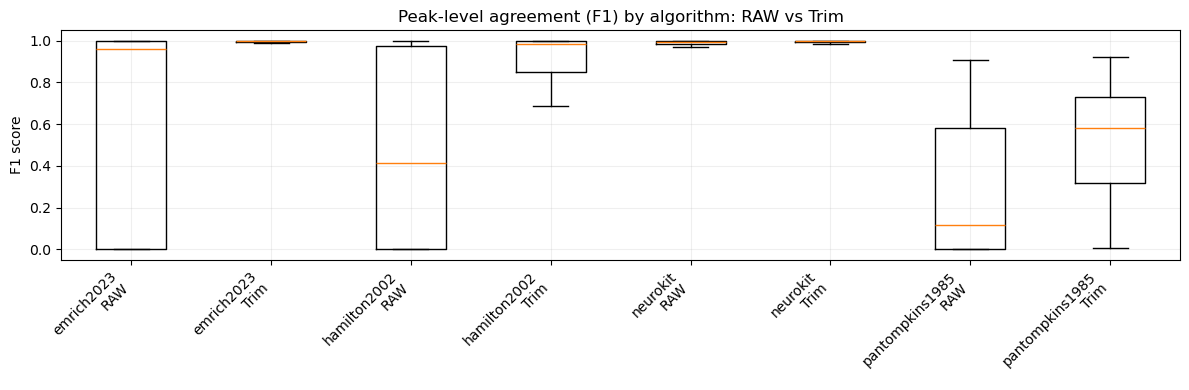

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_13520\2371427483.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


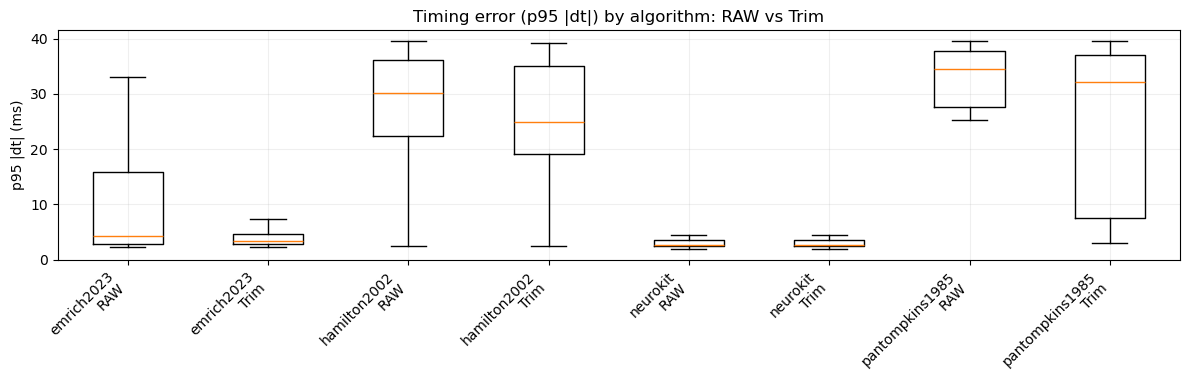

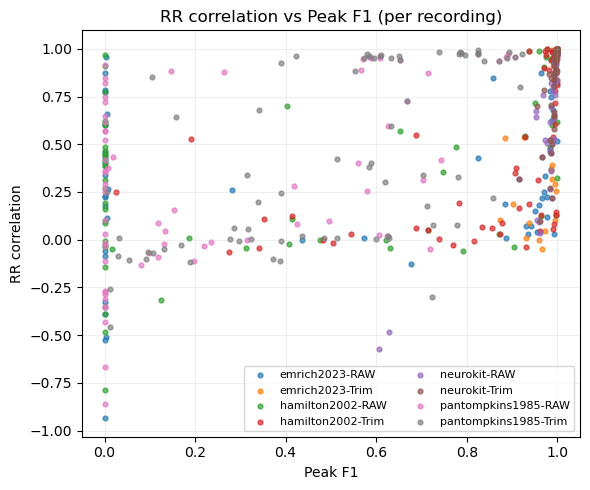

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load (tilpas stier)
df_raw  = pd.read_csv(r"E:\Speciale - Results\study3\Study3_RRCompare_metrics_RAW.csv")
df_trim = pd.read_csv(r"E:\Speciale - Results\study3\Study3_RRCompare_metrics_Trim.csv")

df_raw["run"] = "RAW"
df_trim["run"] = "Trim"
df = pd.concat([df_raw, df_trim], ignore_index=True)

# --- Figur A: peak_f1 boxplot pr algo (RAW vs Trim)
def boxplot_by_algo(df, ycol, title, ylabel):
    algos = sorted(df["algo_id"].unique())
    runs = ["RAW", "Trim"]
    data = []
    labels = []
    for a in algos:
        for r in runs:
            v = df.loc[(df["algo_id"] == a) & (df["run"] == r), ycol].dropna().values
            data.append(v)
            labels.append(f"{a}\n{r}")
    plt.figure(figsize=(12, 4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()

boxplot_by_algo(df, "peak_f1", "Peak-level agreement (F1) by algorithm: RAW vs Trim", "F1 score")
plt.show()

# --- Figur B: p95_abs_dt_ms boxplot
boxplot_by_algo(df, "p95_abs_dt_ms", "Timing error (p95 |dt|) by algorithm: RAW vs Trim", "p95 |dt| (ms)")
plt.show()

# --- Figur C: scatter peak_f1 vs rr_corr
plt.figure(figsize=(6, 5))
for (algo, run), g in df.groupby(["algo_id", "run"]):
    plt.scatter(g["peak_f1"], g["rr_corr"], label=f"{algo}-{run}", s=12, alpha=0.7)
plt.xlabel("Peak F1")
plt.ylabel("RR correlation")
plt.title("RR correlation vs Peak F1 (per recording)")
plt.grid(True, alpha=0.2)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load (tilpas stier)
df_raw  = pd.read_csv("Study3_RRCompare_metrics_RAW.csv")
df_trim = pd.read_csv("Study3_RRCompare_metrics_Trim.csv")

df_raw["run"] = "RAW"
df_trim["run"] = "Trim"
df = pd.concat([df_raw, df_trim], ignore_index=True)

# --- Figur A: peak_f1 boxplot pr algo (RAW vs Trim)
def boxplot_by_algo(df, ycol, title, ylabel):
    algos = sorted(df["algo_id"].unique())
    runs = ["RAW", "Trim"]
    data = []
    labels = []
    for a in algos:
        for r in runs:
            v = df.loc[(df["algo_id"] == a) & (df["run"] == r), ycol].dropna().values
            data.append(v)
            labels.append(f"{a}\n{r}")
    plt.figure(figsize=(12, 4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()

boxplot_by_algo(df, "peak_f1", "Peak-level agreement (F1) by algorithm: RAW vs Trim", "F1 score")
plt.show()

# --- Figur B: p95_abs_dt_ms boxplot
boxplot_by_algo(df, "p95_abs_dt_ms", "Timing error (p95 |dt|) by algorithm: RAW vs Trim", "p95 |dt| (ms)")
plt.show()

# --- Figur C: scatter peak_f1 vs rr_corr
plt.figure(figsize=(6, 5))
for (algo, run), g in df.groupby(["algo_id", "run"]):
    plt.scatter(g["peak_f1"], g["rr_corr"], label=f"{algo}-{run}", s=12, alpha=0.7)
plt.xlabel("Peak F1")
plt.ylabel("RR correlation")
plt.title("RR correlation vs Peak F1 (per recording)")
plt.grid(True, alpha=0.2)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [8]:
# print(df_metrics["overlap_start"], df_metrics["overlap_end"], df_metrics["best_delta_s"], df_metrics["peak_f1"],df_metrics["offset0_s"],df_metrics["n_peaks_tp"],df_metrics["peak_f1"])
# df = df_metrics.copy()

# cols = ["patient_id","recording_id","algo_id","n_common","rr_mae_ms","rr_corr","peak_f1",
#         "n_peaks_labview_total","n_peaks_python_total","n_peaks_tp","n_peaks_fp","n_peaks_fn","best_delta_s"]

# print(df[cols].sort_values(["patient_id","recording_id","algo_id"]))
# print("\nNaN count:\n", df[cols].isna().sum())

# dfp = df.copy()
# dfp["peak_ratio_py_vs_lv"] = dfp["n_peaks_python_total"] / dfp["n_peaks_labview_total"]
# print(dfp[["algo_id","n_peaks_labview_total","n_peaks_python_total","peak_ratio_py_vs_lv","peak_f1"]])

# d = df[df["algo_id"]=="neurokit"].iloc[0]
# print("best_delta_s:", d["best_delta_s"])
# for k in ["rr_mae_ms","rr_rmse_ms","rr_corr","peak_f1","n_common","n_peaks_tp","n_peaks_fp","n_peaks_fn"]:
#     print(k, "=", d[k])


RR/peak comparison: 100%|██████████| 21/21 [07:00<00:00, 20.02s/it]


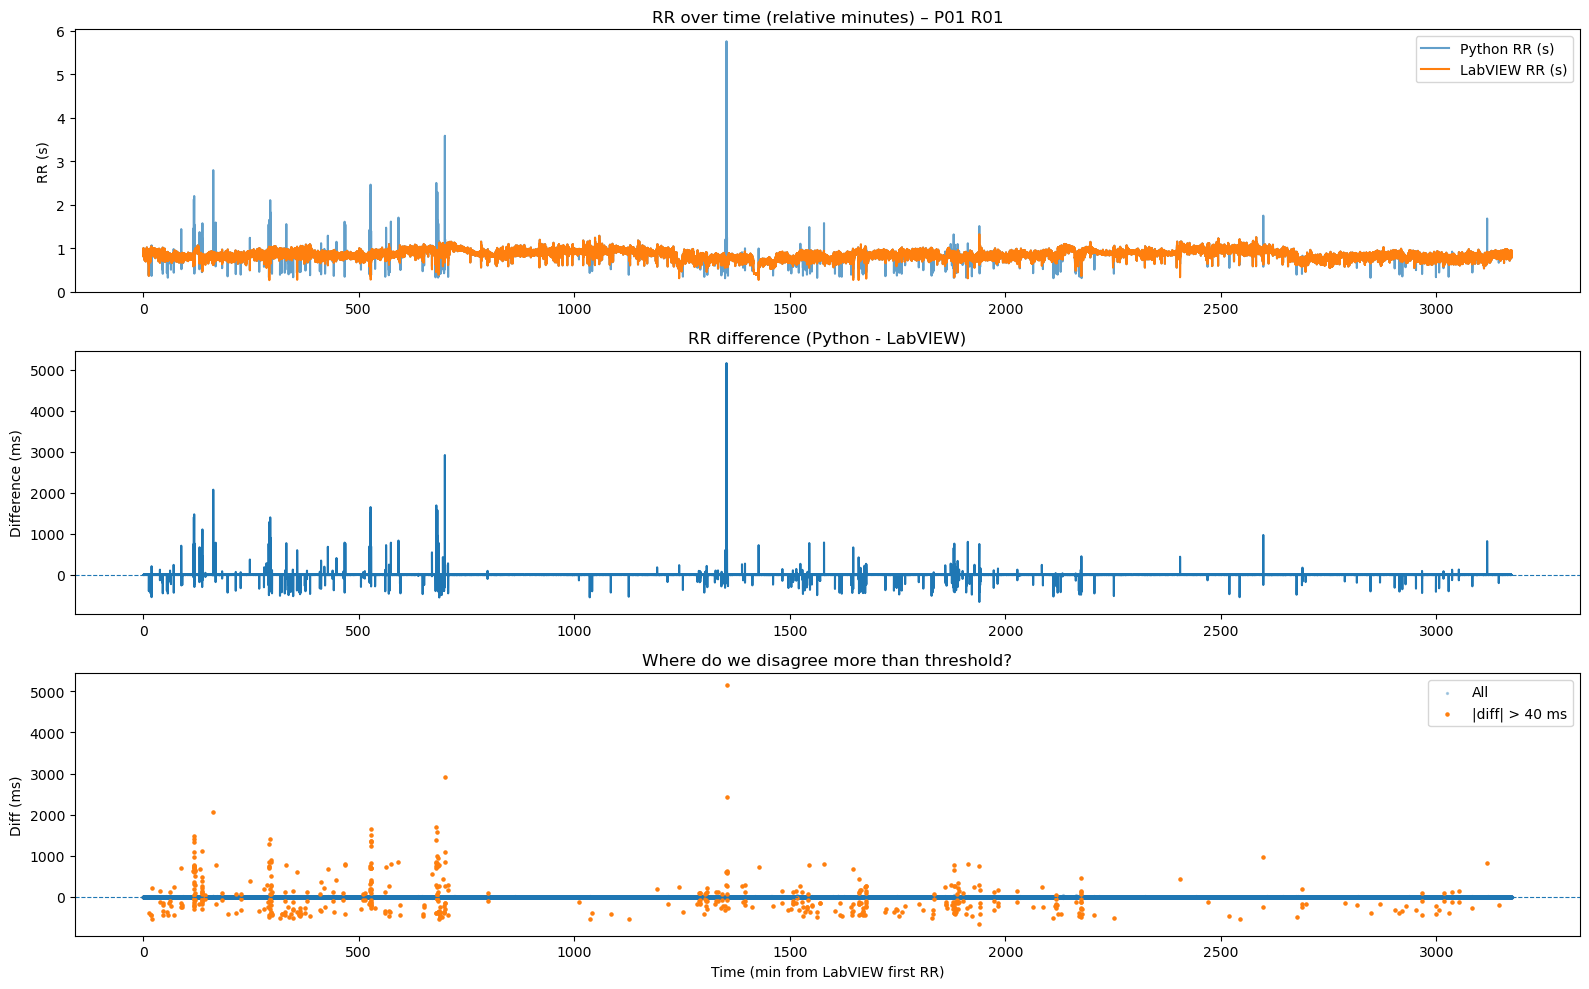

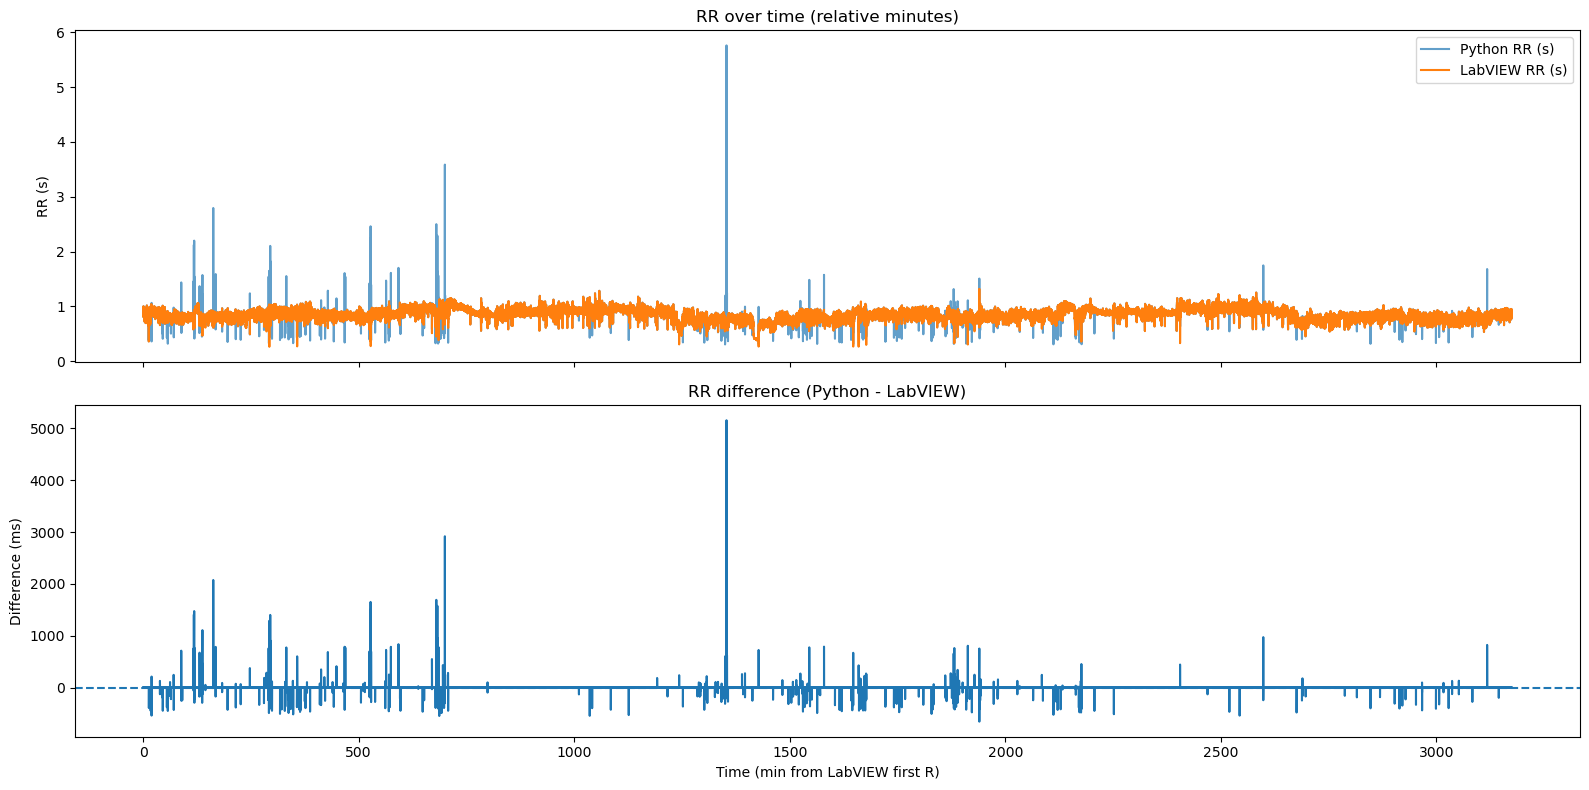

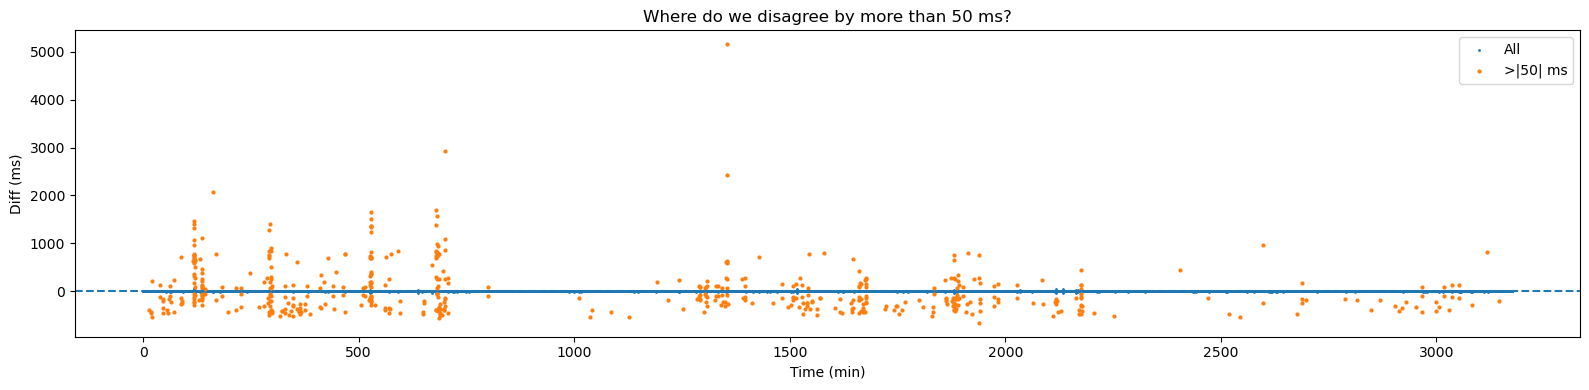

min RR_py (s) = 0.302734375
max RR_py (s) = 13.02734375
RR_py > 10 s: 1
largest 10 RR_py (s): [ 3.90429688  4.25976562  4.33984375  4.40039062  5.45507812  5.70117188
  5.75976562  6.19921875  7.20703125 13.02734375]
0.306640625 5.759765625
0    0.861328
1    0.871094
2    0.859375
3    0.865234
4    0.849609
Name: RR_python_s, dtype: float64


RR/peak comparison: 100%|██████████| 12/12 [05:21<00:00, 26.81s/it]


,n_common,rr_mae_ms,rr_rmse_ms,rr_corr,mean_hr_ref_bpm,mean_hr_test_bpm,mean_hr_diff_bpm,patient_id,recording_id,algo_id,...,raw_tdms_path,raw_lvm_path,n_peaks_labview_total,n_peaks_python_total,n_peaks_tp,n_peaks_fp,n_peaks_fn,peak_sens,peak_ppv,peak_f1
0,226526,2.022334,25.807871,0.968365,71.356255,71.349465,-0.006790,1,1,neurokit,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,226869,227278,226445,407,424,0.998131,0.998206,0.998168
1,53696,43.244543,1865.566087,0.027800,81.810770,80.567938,-1.242832,1,1,pantompkins1985,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,226869,203740,13597,189771,213272,0.059933,0.066859,0.063207
2,189718,19.472615,165.399304,0.433911,70.017463,69.971936,-0.045527,1,1,hamilton2002,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,226869,217656,74276,143011,152593,0.327396,0.341834,0.334459
3,167612,1.626953,13.826275,0.990152,68.878174,68.888089,0.009915,1,2,neurokit,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,167720,168576,167584,173,136,0.999189,0.998969,0.999079
4,73756,21.908126,104.188776,0.425915,63.534060,63.298159,-0.235901,1,2,pantompkins1985,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,167720,151775,9607,141788,156563,0.057814,0.063457,0.060504


In [4]:
from pathlib import Path
from Study3_R_peak_val import run_rr_comparison_from_df  # tilpas import-sti

aligned_dir = Path(r"E:\Speciale - Results\RR_alignment\aligned_rr_p01-05-29")

df_metrics = run_rr_comparison_from_df(
    df_index=df_index,
    methods=methods,
    aligned_dir=aligned_dir,
    patient_filter=patients,          # [1, 5, 29]
    delta_range_s=(-2.0, 2.0),
    delta_step_s=0.05,
    tol_s=0.15,
)

out_metrics_path = Path(r"E:\Speciale - Results\RR_alignment\rr_peak_metrics_p01-05-29.csv")
out_metrics_path.parent.mkdir(parents=True, exist_ok=True)
df_metrics.to_csv(out_metrics_path, index=False)
df_metrics.head()


In [5]:
df_metrics

,n_common,rr_mae_ms,rr_rmse_ms,rr_corr,mean_hr_ref_bpm,mean_hr_test_bpm,mean_hr_diff_bpm,patient_id,recording_id,algo_id,...,raw_tdms_path,raw_lvm_path,n_peaks_labview_total,n_peaks_python_total,n_peaks_tp,n_peaks_fp,n_peaks_fn,peak_sens,peak_ppv,peak_f1
0,226526,2.022334,25.807871,0.968365,71.356255,71.349465,-0.006790,1,1,neurokit,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,226869,227278,226445,407,424,0.998131,0.998206,0.998168
1,53696,43.244543,1865.566087,0.027800,81.810770,80.567938,-1.242832,1,1,pantompkins1985,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,226869,203740,13597,189771,213272,0.059933,0.066859,0.063207
2,189718,19.472615,165.399304,0.433911,70.017463,69.971936,-0.045527,1,1,hamilton2002,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,226869,217656,74276,143011,152593,0.327396,0.341834,0.334459
3,167612,1.626953,13.826275,0.990152,68.878174,68.888089,0.009915,1,2,neurokit,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,167720,168576,167584,173,136,0.999189,0.998969,0.999079
4,73756,21.908126,104.188776,0.425915,63.534060,63.298159,-0.235901,1,2,pantompkins1985,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,167720,151775,9607,141788,156563,0.057814,0.063457,0.060504
5,118220,18.675879,32.287766,0.871621,65.223326,65.321845,0.098519,1,2,hamilton2002,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,167720,163179,36056,126315,131664,0.214977,0.222059,0.218461
6,165982,1.723571,14.670238,0.994952,63.084296,63.099275,0.014979,5,1,neurokit,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,166026,167188,4,166088,166022,0.000024,0.000024,0.000024
7,0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,pantompkins1985,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,166026,77,0,0,166026,0.000000,NaN,NaN
8,0,NaN,NaN,NaN,NaN,NaN,NaN,5,1,hamilton2002,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,166026,89,0,0,166026,0.000000,NaN,NaN
9,348297,6.075896,83.469472,0.667793,85.285539,84.845285,-0.440254,29,1,neurokit,...,E:\ML algoritme tl anfaldsdetektion vha HRV\eP...,E:\Speciale - Results\Final-LabView-Trim-Tests...,351337,352357,347916,1117,3421,0.990263,0.996800,0.993521


In [6]:
cols_interest = [
    "patient_id", "recording_id", "algo_id",
    "peak_sens", "peak_ppv", "peak_f1",
    "rr_mae_ms", "rr_rmse_ms", "rr_corr",
    "n_peaks_labview_total", "n_peaks_python_total", "n_peaks_tp", "n_peaks_fp", "n_peaks_fn",
]

df_summary = df_metrics[cols_interest].copy()

# Evt. aggreger pr. patient+metode (hvis fx P1 har 2 recordings)
df_summary_patient = (
    df_summary
    .groupby(["patient_id", "algo_id"], as_index=False)
    .agg({
        "peak_sens": "mean",
        "peak_ppv": "mean",
        "peak_f1": "mean",
        "rr_mae_ms": "mean",
        "rr_rmse_ms": "mean",
        "rr_corr": "mean",
    })
)

df_summary_patient


,patient_id,algo_id,peak_sens,peak_ppv,peak_f1,rr_mae_ms,rr_rmse_ms,rr_corr
0,1,hamilton2002,0.271187,0.281946,0.276460,19.074247,98.843535,0.652766
1,1,neurokit,0.998660,0.998587,0.998624,1.824644,19.817073,0.979258
2,1,pantompkins1985,0.058874,0.065158,0.061856,32.576334,984.877432,0.226858
3,5,hamilton2002,0.000000,NaN,NaN,NaN,NaN,NaN
4,5,neurokit,0.000024,0.000024,0.000024,1.723571,14.670238,0.994952
5,5,pantompkins1985,0.000000,NaN,NaN,NaN,NaN,NaN
6,29,hamilton2002,0.185070,0.370270,0.246789,275.176862,24363.563290,-0.015445
7,29,neurokit,0.990263,0.996800,0.993521,6.075896,83.469472,0.667793
8,29,pantompkins1985,0.003677,0.261963,0.007253,12009.800037,149980.991192,-0.234927


In [7]:
df_q = pd.read_csv(r"E:\Speciale - Results\Datastruct\_analysis\study2\recording_quality_overview.csv")
merge_cols = ["patient_id", "recording_id"]

df_all = df_metrics.merge(
    df_q,
    on=merge_cols,
    how="left",
    suffixes=("", "_q"),
)

cols_for_corr = [
    "rr_mae_ms",
    "peak_f1",
    "frac_noiseburst_windows",
    "frac_flatline_windows",
    "hf_ratio",
    "qrs_power_ratio",
    "spectral_uniqueness_score",
]


df_corr = df_all[cols_for_corr].corr()
df_corr

# set(cols_for_corr) - set(df_all.columns)

,rr_mae_ms,peak_f1,frac_noiseburst_windows,frac_flatline_windows,hf_ratio,qrs_power_ratio,spectral_uniqueness_score
rr_mae_ms,1.000000,-0.318955,0.520692,-0.114946,0.474851,-0.485028,-0.176042
peak_f1,-0.318955,1.000000,0.038921,-0.319656,0.131228,-0.000173,-0.018443
frac_noiseburst_windows,0.520692,0.038921,1.000000,-0.332885,0.874560,-0.924264,-0.345861
frac_flatline_windows,-0.114946,-0.319656,-0.332885,1.000000,-0.695646,0.091031,-0.024975
hf_ratio,0.474851,0.131228,0.874560,-0.695646,1.000000,-0.640836,-0.029276
qrs_power_ratio,-0.485028,-0.000173,-0.924264,0.091031,-0.640836,1.000000,0.636260
spectral_uniqueness_score,-0.176042,-0.018443,-0.345861,-0.024975,-0.029276,0.636260,1.000000


In [8]:
# Check column names if needed
# print(df_metrics.columns.tolist())
# print(df_q.columns.tolist())


In [9]:
cols_keep = [
    "patient_id", "recording_id", "algo_id",
    "peak_sens", "peak_ppv", "peak_f1",
    "rr_mae_ms", "rr_rmse_ms", "rr_corr"
]

df_perf = df_metrics[cols_keep].copy()
df_perf.sort_values(["patient_id", "recording_id", "algo_id"])


,patient_id,recording_id,algo_id,peak_sens,peak_ppv,peak_f1,rr_mae_ms,rr_rmse_ms,rr_corr
2,1,1,hamilton2002,0.327396,0.341834,0.334459,19.472615,165.399304,0.433911
0,1,1,neurokit,0.998131,0.998206,0.998168,2.022334,25.807871,0.968365
1,1,1,pantompkins1985,0.059933,0.066859,0.063207,43.244543,1865.566087,0.027800
5,1,2,hamilton2002,0.214977,0.222059,0.218461,18.675879,32.287766,0.871621
3,1,2,neurokit,0.999189,0.998969,0.999079,1.626953,13.826275,0.990152
4,1,2,pantompkins1985,0.057814,0.063457,0.060504,21.908126,104.188776,0.425915
8,5,1,hamilton2002,0.000000,NaN,NaN,NaN,NaN,NaN
6,5,1,neurokit,0.000024,0.000024,0.000024,1.723571,14.670238,0.994952
7,5,1,pantompkins1985,0.000000,NaN,NaN,NaN,NaN,NaN
11,29,1,hamilton2002,0.185070,0.370270,0.246789,275.176862,24363.563290,-0.015445


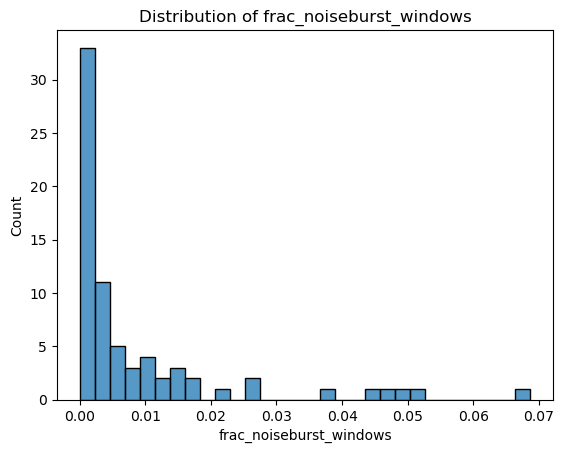


frac_noiseburst_windows percentiles:
0.50    0.003213
0.75    0.010649
0.90    0.025132
0.95    0.045947
Name: frac_noiseburst_windows, dtype: float64


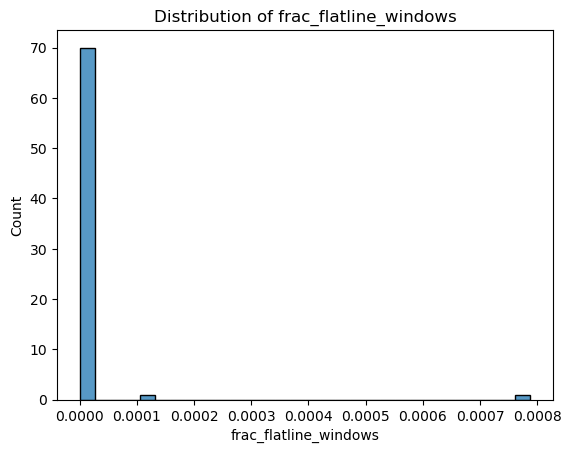


frac_flatline_windows percentiles:
0.50    0.0
0.75    0.0
0.90    0.0
0.95    0.0
Name: frac_flatline_windows, dtype: float64


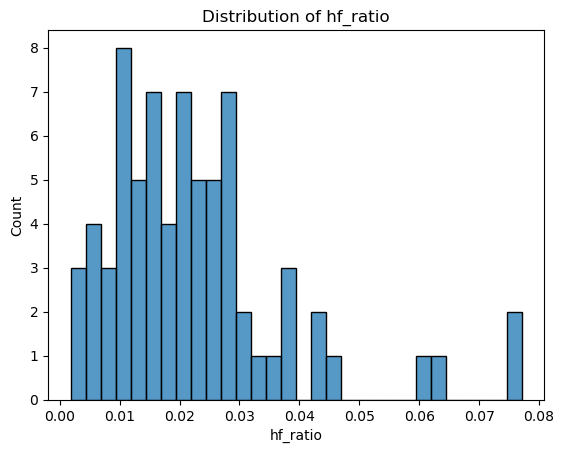


hf_ratio percentiles:
0.50    0.020197
0.75    0.027526
0.90    0.039267
0.95    0.051548
Name: hf_ratio, dtype: float64


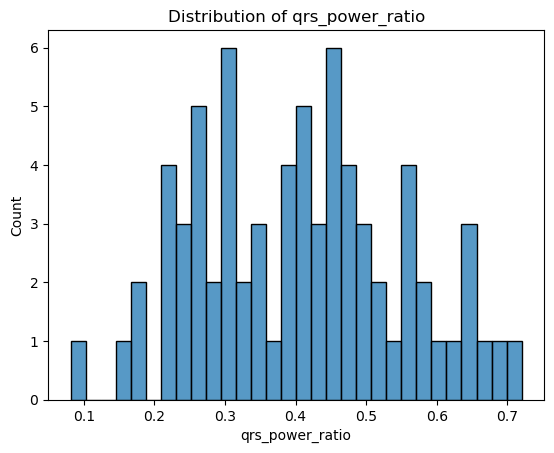


qrs_power_ratio percentiles:
0.50    0.409239
0.75    0.495285
0.90    0.596291
0.95    0.644480
Name: qrs_power_ratio, dtype: float64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Antag df_q er allerede loadet
features = [
    "frac_noiseburst_windows",
    "frac_flatline_windows",
    "hf_ratio",
    "qrs_power_ratio",
]

percentiles = [0.5, 0.75, 0.9, 0.95]

for feat in features:
    fig, ax = plt.subplots()
    sns.histplot(df_q[feat].dropna(), bins=30, ax=ax)
    ax.set_title(f"Distribution of {feat}")
    plt.show()

    print(f"\n{feat} percentiles:")
    print(df_q[feat].quantile(percentiles))


In [11]:
merge_cols = ["patient_id", "recording_id"]

df_all = df_metrics.merge(
    df_q,
    on=merge_cols,
    how="left",
    suffixes=("", "_q"),
)

# Vi fokuserer på NeuroKit, så algoritmeeffekter ikke mudrer billedet
df_nk = df_all[df_all["algo_id"] == "neurokit"].copy()


In [12]:
qual_feats = [
    "frac_noiseburst_windows",
    "frac_flatline_windows",
    "hf_ratio",
    "qrs_power_ratio",
]

for feat in qual_feats:
    label = feat + "_tert"
    s = df_nk[feat].dropna()

    # Hvis der er for få unikke værdier, giver tertiler ingen mening
    if s.nunique() < 3:
        print(f"Skipping tertiles for {feat} (only {s.nunique()} unique values)")
        continue

    df_nk[label] = pd.qcut(
        df_nk[feat],
        3,
        labels=["low", "mid", "high"],
        duplicates="drop",   # håndterer næsten-ens bins
    )

    grp = (
        df_nk
        .groupby(label)[["rr_mae_ms", "rr_rmse_ms", "peak_f1"]]
        .agg(["mean", "median", "count"])
    )
    print(f"\n=== {feat} tertiles vs RR error ===")
    print(grp)



=== frac_noiseburst_windows tertiles vs RR error ===
                             rr_mae_ms                 rr_rmse_ms             \
                                  mean    median count       mean     median   
frac_noiseburst_windows_tert                                                   
low                           1.675262  1.675262     2  14.248257  14.248257   
mid                                NaN       NaN     0        NaN        NaN   
high                          4.049115  4.049115     2  54.638672  54.638672   

                                     peak_f1                  
                             count      mean    median count  
frac_noiseburst_windows_tert                                  
low                              2  0.499552  0.499552     2  
mid                              0       NaN       NaN     0  
high                             2  0.995845  0.995845     2  
Skipping tertiles for frac_flatline_windows (only 2 unique values)

=== hf_ratio tertil

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_1808\4152702973.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(label)[["rr_mae_ms", "rr_rmse_ms", "peak_f1"]]
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_1808\4152702973.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(label)[["rr_mae_ms", "rr_rmse_ms", "peak_f1"]]
C:\Users\kvjkv\AppData\Local\Temp\ipykernel_1808\4152702973.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

In [13]:
df_nk["any_flatline"] = df_nk["frac_flatline_windows"] > 0

grp_flat = (
    df_nk
    .groupby("any_flatline")[["rr_mae_ms", "rr_rmse_ms", "peak_f1"]]
    .agg(["mean", "median", "count"])
)

print(grp_flat)


             rr_mae_ms                 rr_rmse_ms                    peak_f1  \
                  mean    median count       mean     median count      mean   
any_flatline                                                                   
False         3.241728  2.022334     3  41.034539  25.807871     3  0.996923   
True          1.723571  1.723571     1  14.670238  14.670238     1  0.000024   

                              
                median count  
any_flatline                  
False         0.998168     3  
True          0.000024     1  


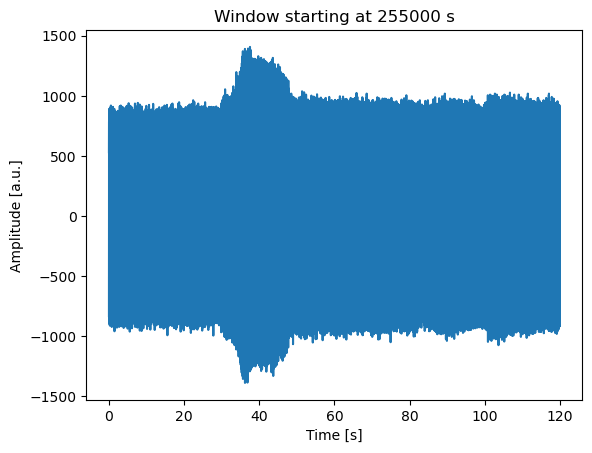

255950.5

In [14]:
import numpy as np
from src.hrv_epatch.io.tdms import load_tdms_from_path

# Du skal selv hente signal og fs (sampling frequency) for f.eks. Patient 29, recording 1
# pseudo:
sig, meta = load_tdms_from_path(df_rec[(df_rec["patient_id"] == 29) & (df_rec["recording_id"] == 1)]["tdms_path"].iloc[0])
fs = meta.fs

def plot_window(sig, fs, start_s, duration_s=10):
    start_idx = int(start_s * fs)
    end_idx = start_idx + int(duration_s * fs)
    t = np.arange(end_idx - start_idx) / fs
    plt.figure()
    plt.plot(t, sig[start_idx:end_idx])
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [a.u.]")
    plt.title(f"Window starting at {start_s} s")
    plt.show()



plot_window(sig, fs, start_s=255000, duration_s=120)

meta.n_samples/fs

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def compute_window_metrics(sig, fs, win_s=10):
    win_n = int(win_s * fs)
    n_win = len(sig) // win_n
    rows = []

    for i in range(n_win):
        x = sig[i*win_n : (i+1)*win_n]
        if len(x) < win_n:
            break

        std = np.std(x)
        rng = x.max() - x.min()

        # Spektral info (meget simpel FFT-baseret)
        freqs = np.fft.rfftfreq(win_n, d=1/fs)
        psd = np.abs(np.fft.rfft(x))**2

        total_power = psd.sum()
        band_hf = psd[(freqs >= 40) & (freqs <= 100)].sum()
        band_qrs = psd[(freqs >= 5) & (freqs <= 25)].sum()

        hf_ratio = band_hf / total_power if total_power > 0 else 0.0
        qrs_ratio = band_qrs / total_power if total_power > 0 else 0.0

        rows.append({
            "win_idx": i,
            "start_s": i * win_s,
            "std": std,
            "range": rng,
            "hf_ratio_win": hf_ratio,
            "qrs_ratio_win": qrs_ratio,
        })

    return pd.DataFrame(rows)


def plot_window(sig, fs, start_s, duration_s=10, title="Window"):
    start = int(start_s * fs)
    end = start + int(duration_s * fs)
    t = np.arange(end - start) / fs

    plt.figure()
    plt.plot(t, sig[start:end])
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [a.u.]")
    plt.title(title)
    plt.show()


High noiseburst: window 24812.0 starting at 248120.0 s


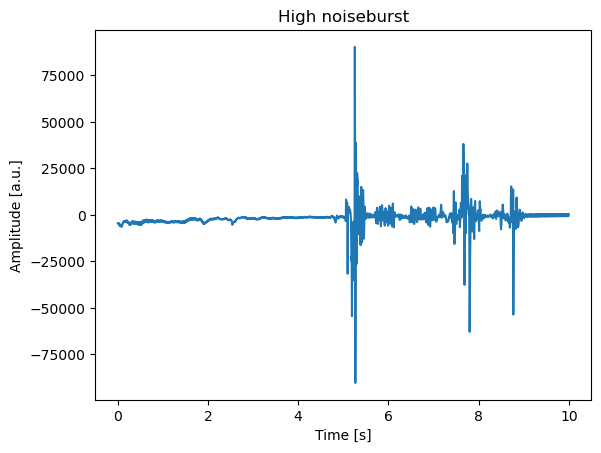

High HF ratio: window 25469.0 starting at 254690.0 s


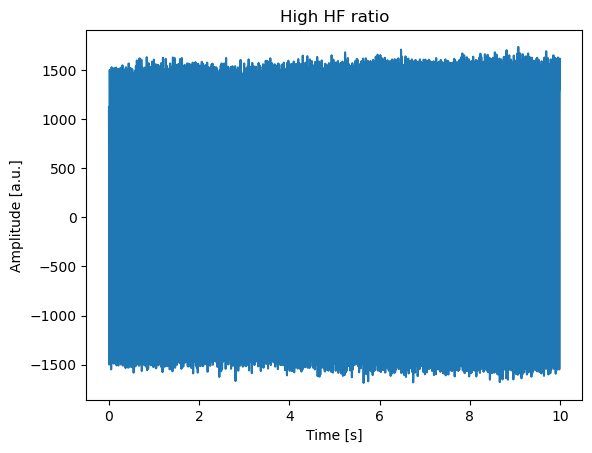

Low-variance / flatline: window 1868.0 starting at 18680.0 s


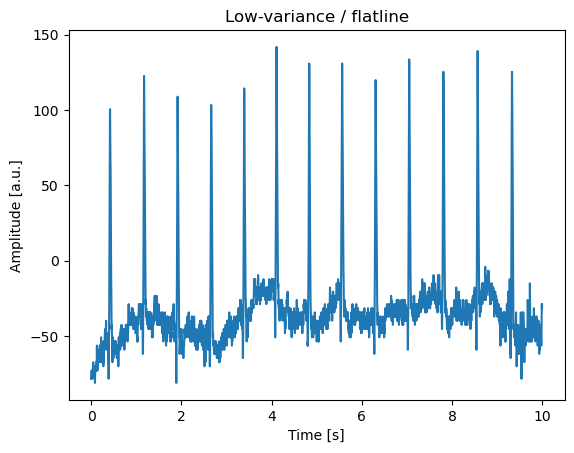

Baseline-like: window 14068.0 starting at 140680.0 s


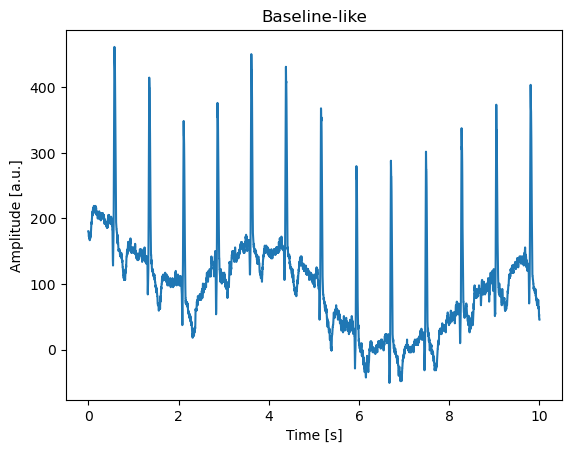

In [16]:
row_29 = df_nk[(df_nk["patient_id"] == 29) & (df_nk["recording_id"] == 1)].iloc[0]
sig, meta = load_tdms_from_path(row_29["raw_tdms_path"])
fs = meta.fs

df_win = compute_window_metrics(sig, fs, win_s=10)

# 1) Vælg vindue med højeste range (= noiseburst)
w_noise = df_win.sort_values("range", ascending=False).iloc[0]

# 2) Vælg vindue med højeste hf_ratio_win
w_hf = df_win.sort_values("hf_ratio_win", ascending=False).iloc[0]

# 3) Vælg vindue med laveste std (= flatline-ish)
w_flat = df_win.sort_values("std", ascending=True).iloc[0]

# 4) Vælg "pænt" baseline-vindue (median std)
w_baseline = df_win.iloc[(df_win["std"] - df_win["std"].median()).abs().argmin()]

for label, w in [
    ("High noiseburst", w_noise),
    ("High HF ratio", w_hf),
    ("Low-variance / flatline", w_flat),
    ("Baseline-like", w_baseline),
]:
    print(f"{label}: window {w['win_idx']} starting at {w['start_s']} s")
    plot_window(sig, fs, start_s=w["start_s"], duration_s=10, title=label)


In [17]:
def find_true_flatline_windows(sig, fs, win_s=10, std_thresh=5, range_thresh=30):
    win_n = int(win_s * fs)
    n_win = len(sig) // win_n
    segments = []

    for i in range(n_win):
        x = sig[i*win_n : (i+1)*win_n]
        std = np.std(x)
        rng = x.max() - x.min()

        if std < std_thresh and rng < range_thresh:
            segments.append(i)

    return segments



Patient 1:
Total duration: 191135.8 s
Found 0 potential flatline windows out of 19113 total windows
Flatline window indices: []
No flatline segments found.

Patient 5:
Total duration: 161055.2 s
Found 174 potential flatline windows out of 16105 total windows
Flatline window indices: [15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15938, 15939, 15940, 15941, 15942, 15943, 15944, 15945, 15946, 15947, 15948, 15949, 15950, 15951, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15960, 15961, 15962, 15963, 15964, 15965, 15966, 15967, 15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15977, 15978, 15979, 15980, 15981, 15982, 15983, 15984, 15985, 15986, 15987, 15988, 15989, 15990, 15991, 15992, 15993, 15994, 15995, 15996, 15997, 15998, 15999, 16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008, 16009, 16010, 16011, 16012, 16013, 16014, 16015, 16016, 16017, 16018, 16019, 16020, 16021, 16022, 16023, 16024, 16025, 16026, 16027, 16028, 16029, 16030, 

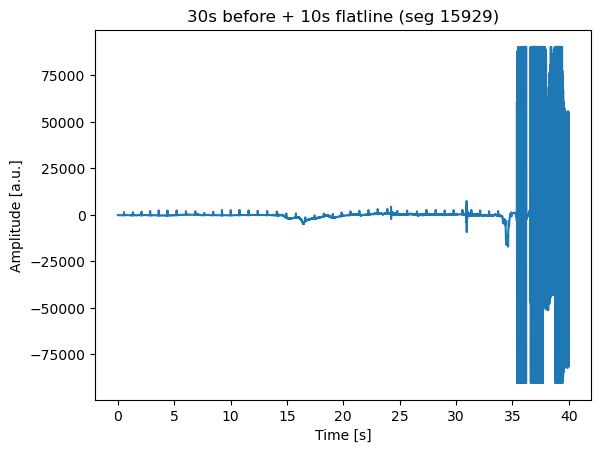

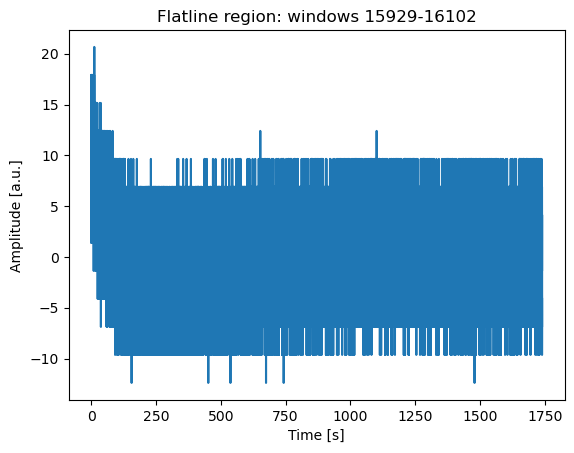

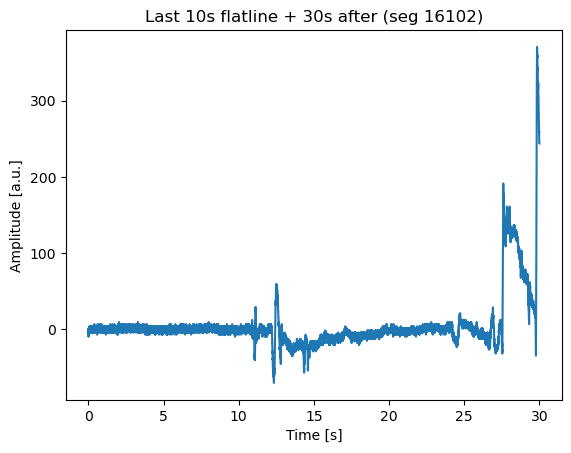

In [18]:
for pid in [1, 5]:
    row = df_nk[(df_nk["patient_id"] == pid) & (df_nk["recording_id"] == 1)].iloc[0]
    sig, meta = load_tdms_from_path(row["raw_tdms_path"])
    fs = meta.fs

    flatline_segments_full = find_true_flatline_windows(sig, fs, win_s=10, std_thresh=5, range_thresh=30)

    print(f"\nPatient {pid}:")
    print(f"Total duration: {meta.n_samples/meta.fs:.1f} s")
    print(f"Found {len(flatline_segments_full)} potential flatline windows out of {len(sig) // int(10*fs)} total windows")
    print(f"Flatline window indices: {flatline_segments_full}")

    if flatline_segments_full:
        first_seg = flatline_segments_full[0]
        last_seg = flatline_segments_full[-1]

        # 1. 30s before first segment + first 10s of flatline
        start_before = max(0, (first_seg - 3) * 10 - 30)
        plot_window(sig, fs, start_s=start_before, duration_s=40, title=f"30s before + 10s flatline (seg {first_seg})")

        # 2. All flatline segments (from first to last)
        start_s = first_seg * 10
        end_s = (last_seg + 1) * 10
        duration_s = end_s - start_s
        plot_window(sig, fs, start_s=start_s, duration_s=duration_s, title=f"Flatline region: windows {first_seg}-{last_seg}")

        # 3. Last 10s flatline + 30s after
        start_last = last_seg * 10
        plot_window(sig, fs, start_s=start_last, duration_s=30, title=f"Last 10s flatline + 30s after (seg {last_seg})")
    else:
        print("No flatline segments found.")


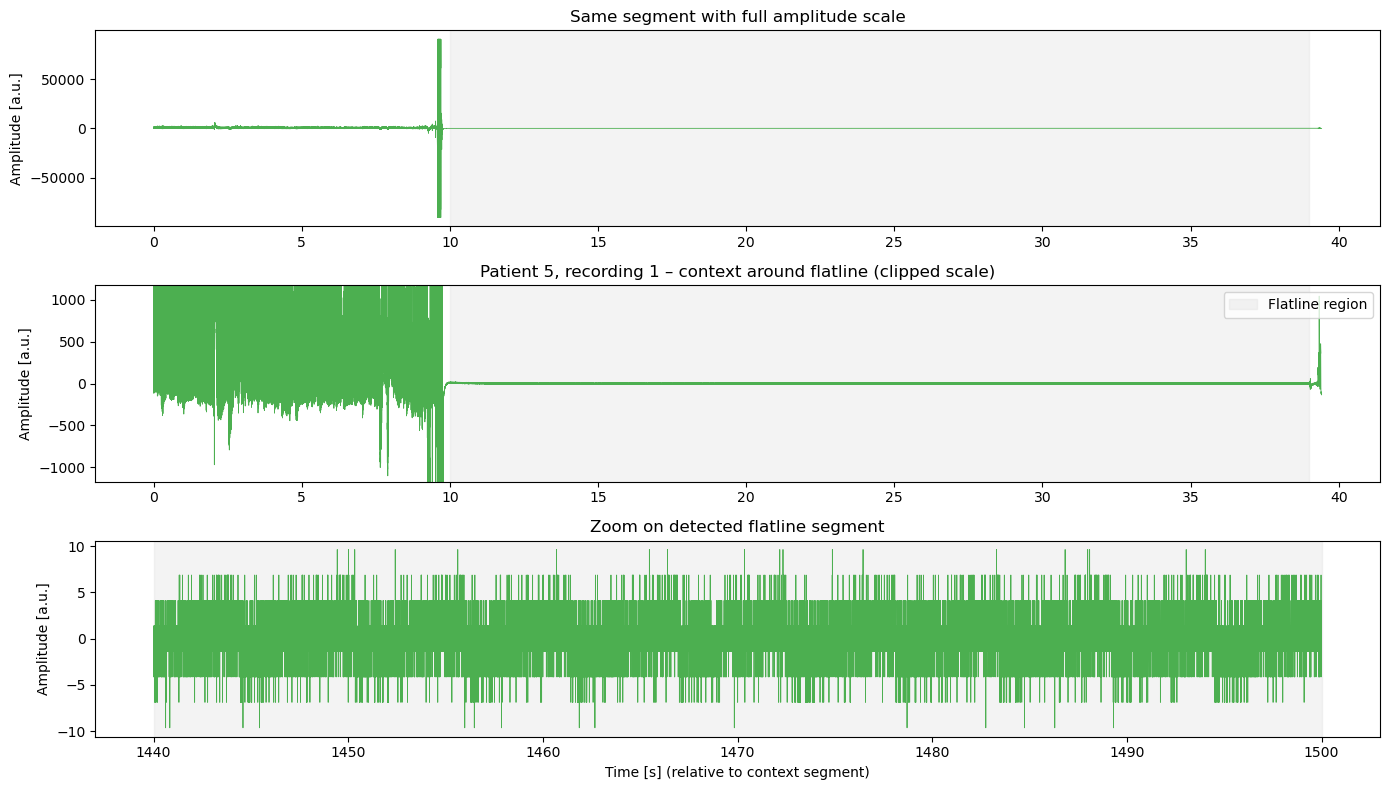

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from src.hrv_epatch.plots.plotstyle import palette

# --- indstil din ECG-farve her ---
ecg_color = palette["primary"]  # skift evt. til din egen grønne

# Patient 5, recording 1
row_5 = df_nk[(df_nk["patient_id"] == 5) & (df_nk["recording_id"] == 1)].iloc[0]
sig, meta = load_tdms_from_path(row_5["raw_tdms_path"])
fs = meta.fs

win_s = 10  # vindueslængde som i flatline-detektoren

first_seg = flatline_segments_full[0]
last_seg = flatline_segments_full[-1]

flat_start_s = first_seg * win_s
flat_end_s   = (last_seg + 1) * win_s

# ~10 min før og efter
margin_before = 10 * 60
margin_after  = 10 * 60

t0 = max(0, flat_start_s - margin_before)
t1 = min(len(sig) / fs, flat_end_s + margin_after)

idx0 = int(t0 * fs)
idx1 = int(t1 * fs)
sig_seg = sig[idx0:idx1]
t_seg = np.arange(idx1 - idx0) / fs  # [s] relativt til t0

flat_start_rel = flat_start_s - t0
flat_end_rel   = flat_end_s - t0

# Zoom: 60 s omkring midten af flatline
zoom_center = (flat_start_s + flat_end_s) / 2
zoom_half   = 30

z0 = max(t0, zoom_center - zoom_half)
z1 = min(t1, zoom_center + zoom_half)

idz0 = int((z0 - t0) * fs)
idz1 = int((z1 - t0) * fs)
sig_zoom = sig_seg[idz0:idz1]
t_zoom = np.arange(idz1 - idz0) / fs + (z0 - t0)

flat_start_zoom = max(flat_start_rel, z0 - t0)
flat_end_zoom   = min(flat_end_rel, z1 - t0)

# robust y-grænse til det "klippede" plot (ignorerer de værste spikes)
y_lim = np.percentile(np.abs(sig_seg), 99)

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=False)

# (a) Kontekst med klippet y-akse
ax_full = axes[0]
ax_full.plot(t_seg / 60, sig_seg, color=ecg_color, linewidth=0.6)
ax_full.axvspan(flat_start_rel / 60, flat_end_rel / 60,
                alpha=0.25, color="lightgrey")
ax_full.set_ylabel("Amplitude [a.u.]")
ax_full.set_title("Same segment with full amplitude scale")

# (b) Samme kontekst, fuld skala (viser spike)
ax = axes[1]
ax.plot(t_seg / 60, sig_seg, color=ecg_color, linewidth=0.6)
ax.axvspan(flat_start_rel / 60, flat_end_rel / 60,
           alpha=0.25, color="lightgrey", label="Flatline region")
ax.set_ylabel("Amplitude [a.u.]")
ax.set_title("Patient 5, recording 1 – context around flatline (clipped scale)")
ax.set_ylim(-y_lim, y_lim)
ax.legend(loc="upper right")

# (c) Zoom på flatline
axz = axes[2]
axz.plot(t_zoom, sig_zoom, color=ecg_color, linewidth=0.6)
axz.axvspan(flat_start_zoom, flat_end_zoom,
            alpha=0.25, color="lightgrey")
axz.set_xlabel("Time [s] (relative to context segment)")
axz.set_ylabel("Amplitude [a.u.]")
axz.set_title("Zoom on detected flatline segment")

plt.tight_layout()
plt.show()


In [20]:
# Antag 10s-vinduer og vi vil undersøge vindue k (f.eks. det der starter ved 30 s i dit relative plot)
k = first_seg - 1  # vinduet lige før flatline-området
start_s = k * 10

# Beregn metrics for det konkrete vindue
x = sig[int(start_s*fs) : int((start_s+10)*fs)]
std = np.std(x)
rng = x.max() - x.min()

print("std:", std, "range:", rng)


std: 14.795047565441715 range: 68.89295796139467


Validating windows 15895 to 15904
Time range: 158950 s to 159050 s


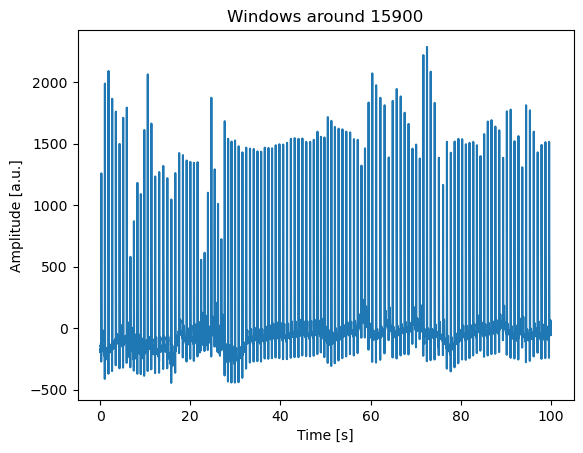


Window metrics in this region:
       win_idx  start_s         std        range  hf_ratio_win
15895    15895   158950   53.775123   416.113466      0.002610
15896    15896   158960   48.605064   385.800565      0.003290
15897    15897   158970  502.671375  2780.519783      0.000369
15898    15898   158980  987.141419  4028.860182      0.000096
15899    15899   158990  316.274303  1394.393469      0.000375
15900    15900   159000  141.399163   983.791440      0.003656
15901    15901   159010  162.368392   920.409918      0.002051
15902    15902   159020   75.013346   642.082368      0.000440
15903    15903   159030  399.389510  2295.513359      0.000243
15904    15904   159040  100.857477   950.722820      0.000786


In [21]:
# Validate segments around window index 15900
win_target = 15900
win_s = 10
fs = 512.0

# Get the target window and surrounding context
start_s = (win_target - 5) * win_s  # 5 windows before
end_s = (win_target + 5) * win_s    # 5 windows after

print(f"Validating windows {win_target - 5} to {win_target + 4}")
print(f"Time range: {start_s} s to {end_s} s")

# Plot the segment
plot_window(sig, fs, start_s=start_s, duration_s=(end_s - start_s), 
            title=f"Windows around {win_target}")

# Compute metrics for this window region
df_region = df_win[(df_win["win_idx"] >= win_target - 5) & 
                    (df_win["win_idx"] <= win_target + 4)]

print("\nWindow metrics in this region:")
print(df_region[["win_idx", "start_s", "std", "range", "hf_ratio_win"]])

In [22]:
def classify_quality(row):
    # Flatline overrides all
    if row["frac_flatline_windows"] > 0:
        return "QL"
    
    # Noiseburst
    if row["frac_noiseburst_windows"] > 0.03:
        return "Q3"
    if row["frac_noiseburst_windows"] > 0.01:
        nb = "Q2"
    else:
        nb = "Q1"

    # HF ratio
    if row["hf_ratio"] > 0.04:
        return "Q3"
    if row["hf_ratio"] > 0.025:
        hf = "Q2"
    else:
        hf = "Q1"

    # QRS ratio
    if row["qrs_power_ratio"] < 0.35:
        return "Q3"
    if row["qrs_power_ratio"] < 0.50:
        qrs = "Q2"
    else:
        qrs = "Q1"

    # Combine
    if "Q3" in [nb, hf, qrs]:
        return "Q3"
    if "Q2" in [nb, hf, qrs]:
        return "Q2"
    return "Q1"


In [23]:
df_q["quality_class"] = df_q.apply(classify_quality, axis=1)
df_q["quality_class"].value_counts()


quality_class
Q3    33
Q2    28
Q1     9
QL     2
Name: count, dtype: int64

In [20]:
import numpy as np
import pandas as pd
import neurokit2 as nk

from src.hrv_epatch.io.tdms import load_tdms_from_path

import numpy as np

from src.hrv_epatch.dataset.quality import (
    _preprocess_for_quality,
    compute_window_quality_vs_seizure,
)

def compute_window_features_for_segment(
    sig_raw,
    fs,
    window_s=10.0,
    flatline_std_thresh=1.0,
    noise_std_factor=5.0,
    clip_range_thresh=0.9,
):
    """
    Kopi af logikken fra compute_window_quality_vs_seizure,
    bare uden seizure-labels og uden at læse TDMS/evt-tabeller.
    Returnerer en DataFrame med én række per 10s-vindue.
    """

    # samme preprocessing som i quality.py
    sig = _preprocess_for_quality(sig_raw, fs)
    sig = np.asarray(sig).astype(float)
    if sig.ndim == 2:
        sig = sig[:, 0]

    n = sig.size
    win_len = int(window_s * fs)
    if n < win_len:
        return pd.DataFrame()

    n_win = n // win_len
    sig_win = sig[: n_win * win_len].reshape(n_win, win_len)

    std_win = np.std(sig_win, axis=1)
    max_win = np.max(sig_win, axis=1)
    min_win = np.min(sig_win, axis=1)
    range_win = max_win - min_win
    diff_abs_med = np.median(np.abs(np.diff(sig_win, axis=1)), axis=1)

    std_med = float(np.median(std_win))
    sig_range = float(np.max(sig) - np.min(sig) + 1e-12)
    noise_std_thresh = noise_std_factor * std_med

    win_starts_s = np.arange(n_win) * window_s
    win_ends_s = win_starts_s + window_s

    is_flat = std_win < flatline_std_thresh
    is_noise = std_win > noise_std_thresh
    is_clip = range_win > (clip_range_thresh * sig_range)

    rows = []
    for i in range(n_win):
        rows.append(
            {
                "window_idx": i,
                "win_start_s": float(win_starts_s[i]),
                "win_end_s": float(win_ends_s[i]),
                "std": float(std_win[i]),
                "range": float(range_win[i]),
                "diff_abs_med": float(diff_abs_med[i]),
                "is_flatline": bool(is_flat[i]),
                "is_noiseburst": bool(is_noise[i]),
                "is_clipping": bool(is_clip[i]),
            }
        )

    return pd.DataFrame(rows)


def is_window_in_seizure(win_start, win_end, seizures):
    """
    seizures: list of (start_s, end_s)
    """
    for s0, s1 in seizures:
        if (win_start < s1) and (win_end > s0):
            return True
    return False


# def analyze_recording_windows(tdms_path, seizure_table, win_s=10, fs=512):
#     sig, meta = load_tdms_from_path(tdms_path)
#     n = len(sig)
#     win_samples = win_s * fs

#     rows = []

#     for start in range(0, n - win_samples, win_samples):
#         segment = sig[start:start+win_samples]

#         # --- OUR SQI FEATURES ---
#         feats = compute_window_features(segment, fs)

#         # classify using thresholds (define outside):
#         sqi_class = classify_quality(feats)

#         # --- NEUROKIT SQI ---
#         try:
#             nk_clean = nk.ecg_clean(segment, sampling_rate=fs)
#             nk_q = nk.ecg_quality(nk_clean, sampling_rate=fs)
#         except:
#             nk_q = np.nan

#         # --- seizure? ---
#         t0 = meta.start_time_s + start/fs
#         in_seizure = is_window_in_seizure(t0, t0+win_s, seizure_table)

#         rows.append({
#             "start_s": start/fs,
#             "patient_id": meta.patient_id,
#             "recording_id": meta.recording_id,

#             # our features
#             **feats,
#             "sqi_class": sqi_class,

#             # NeuroKit
#             "nk_quality": nk_q,

#             # context
#             "is_seizure": in_seizure
#         })

#     return pd.DataFrame(rows)


def compare_models(df):
    summary = pd.DataFrame({
        "model": ["ours", "neurokit"],
        "pct_bad_baseline": [
            (df[(df.is_seizure==False) & (df.sqi_class=="QL")].shape[0] / df[df.is_seizure==False].shape[0]),
            (df[(df.is_seizure==False) & (df.nk_quality < 0.3)].shape[0] / df[df.is_seizure==False].shape[0])
        ],
        "pct_bad_seizure": [
            (df[(df.is_seizure==True) & (df.sqi_class=="QL")].shape[0] / df[df.is_seizure==True].shape[0]),
            (df[(df.is_seizure==True) & (df.nk_quality < 0.3)].shape[0] / df[df.is_seizure==True].shape[0])
        ]
    })
    return summary




In [21]:
df_metrics.head()

NameError: name 'df_metrics' is not defined

In [22]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt


# Example: Patient 5, Recording 1
# Get Patient 5, Recording 1 data from dataframe
row_p5 = df_rec_with_lvm[(df_rec_with_lvm["patient_id"] == 5) & 
                          (df_rec_with_lvm["recording_id"] == 1)].iloc[0]
row_p5.keys

sig, meta = load_tdms_from_path(row_p5["tdms_path"])
fs = meta.fs

# Choose a 4-hour window (you can change this)
start_s = 19 * 3600
end_s   = 25 * 3600
sig_seg = sig[int(start_s*fs):int(end_s*fs)]
t_seg = np.arange(len(sig_seg)) / fs
print(f"Segment duration: {len(sig_seg)/fs/3600:.2f} hours, with {len(sig_seg)} samples.")

Segment duration: 6.00 hours, with 11059200 samples.


In [23]:
# 3) Vores SQI per 10s-vindue (på præprocesseret signal)
df_win = compute_window_features_for_segment(sig_seg, fs, window_s=10.0)

In [24]:
# Clean ECG (NeuroKit)
ecg_clean = nk.ecg_clean(sig_seg, sampling_rate=fs)

# Compute quality values (time series)
nk_q = nk.ecg_quality(ecg_clean, sampling_rate=fs)

print("NK quality length:", len(nk_q))


NK quality length: 11059200


In [25]:
# 3) Vores SQI per 10s-vindue (på præprocesseret signal)
df_win = compute_window_features_for_segment(sig_seg, fs, window_s=10.0)

# 4) NeuroKit kvalitet på hele segmentet
sig_seg = np.asarray(sig_seg).astype(float)
if sig_seg.ndim == 2:
    sig_seg = sig_seg[:, 0]

ecg_clean = nk.ecg_clean(sig_seg, sampling_rate=fs)
nk_q = nk.ecg_quality(ecg_clean, sampling_rate=fs)
nk_q = np.asarray(nk_q)

# 5) Map NK-quality til vores vinduer (median pr. 10s-vindue)
win_len = int(10.0 * fs)
n_win = len(df_win)
nk_vals = []
for i in range(n_win):
    i0 = i * win_len
    i1 = i0 + win_len
    nk_vals.append(float(np.median(nk_q[i0:i1])))

df_win["nk_quality"] = nk_vals

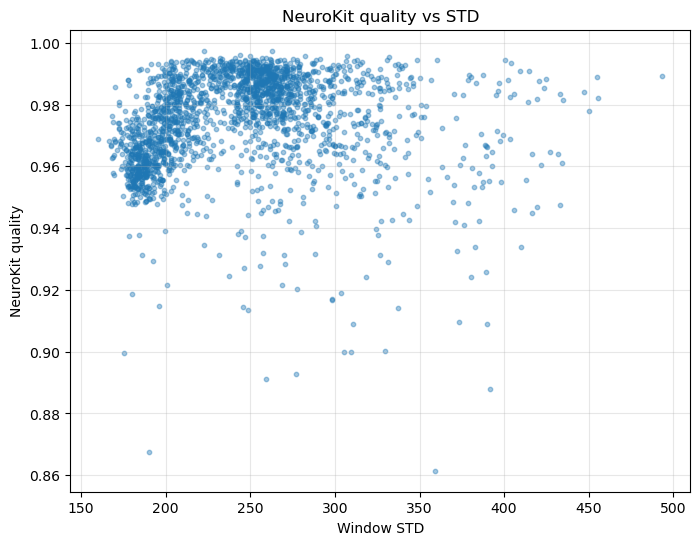

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(df_win["std"], df_win["nk_quality"], s=10, alpha=0.4)
plt.xlabel("Window STD")
plt.ylabel("NeuroKit quality")
plt.title("NeuroKit quality vs STD")
plt.grid(alpha=0.3)
plt.show()


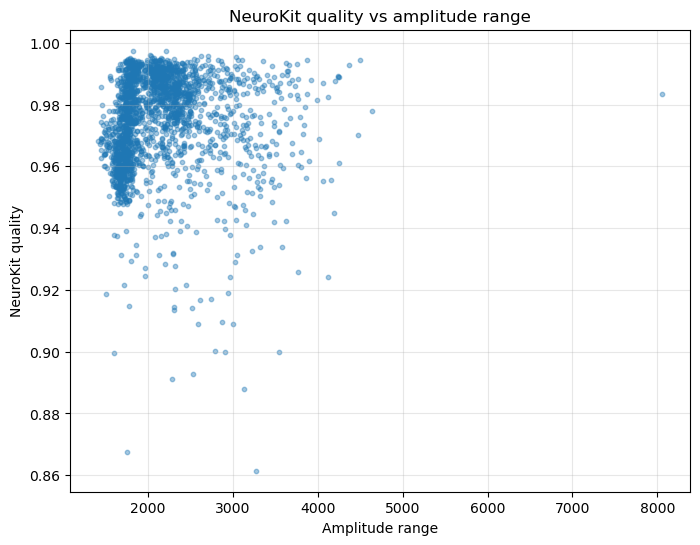

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_win["range"], df_win["nk_quality"], s=10, alpha=0.4)
plt.xlabel("Amplitude range")
plt.ylabel("NeuroKit quality")
plt.title("NeuroKit quality vs amplitude range")
plt.grid(alpha=0.3)
plt.show()

C:\Users\kvjkv\AppData\Local\Temp\ipykernel_25240\2418961380.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


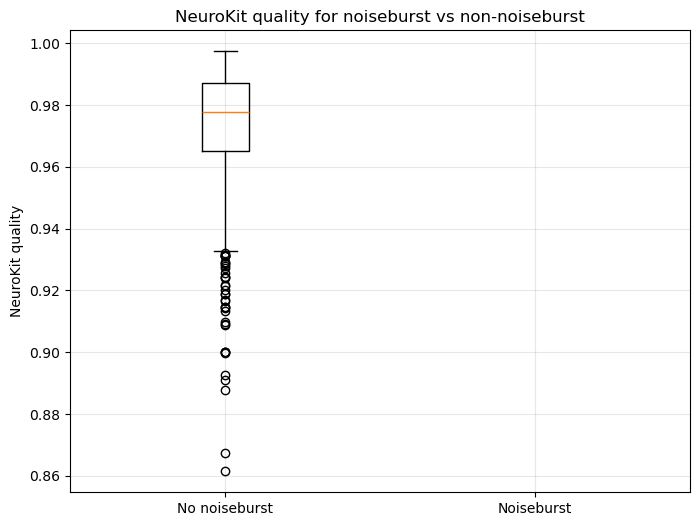

In [29]:
plt.figure(figsize=(8,6))
plt.boxplot(
    [df_win[df_win["is_noiseburst"]==0]["nk_quality"],
     df_win[df_win["is_noiseburst"]==1]["nk_quality"]],
    labels=["No noiseburst", "Noiseburst"]
)
plt.ylabel("NeuroKit quality")
plt.title("NeuroKit quality for noiseburst vs non-noiseburst")
plt.grid(alpha=0.3)
plt.show()


In [30]:
df_win["ours_bad"] = (
    df_win["is_flatline"] |
    df_win["is_noiseburst"] |
    df_win["is_clipping"]
)

df_win["nk_bad"] = df_win["nk_quality"] < 0.3


In [31]:
summary = pd.DataFrame({
    "model": ["ours", "neurokit"],
    "pct_bad": [
        df_win["ours_bad"].mean(),
        df_win["nk_bad"].mean()
    ]
})
summary


,model,pct_bad
0,ours,0.000466
1,neurokit,0.000000


In [32]:
pd.crosstab(df_win["ours_bad"], df_win["nk_bad"],
            rownames=["Ours bad"], colnames=["NeuroKit bad"])


NeuroKit bad,False
Ours bad,
False,2147
True,1


In [34]:
df_win.head()

,window_idx,win_start_s,win_end_s,std,range,diff_abs_med,is_flatline,is_noiseburst,is_clipping,nk_quality,ours_bad,nk_bad
0,0,0.0,10.0,176.860498,1731.791198,0.776479,False,False,False,0.958769,False,False
1,1,10.0,20.0,186.174625,1653.639563,0.783093,False,False,False,0.955785,False,False
2,2,20.0,30.0,185.628910,1797.203614,0.891852,False,False,False,0.959923,False,False
3,3,30.0,40.0,216.179197,2017.565394,0.989161,False,False,False,0.963431,False,False
4,4,40.0,50.0,193.522500,1967.952246,1.039289,False,False,False,0.964024,False,False


In [38]:
def mark_seizure_windows(df_win, annos):
    df_win["is_seizure"] = False
    for _, row in annos.iterrows():
        sz_start = row["seizure_start_s"]
        sz_end = row["seizure_end_s"]
        df_win.loc[
            (df_win.win_start_s < sz_end) & (df_win.win_end_s > sz_start),
            "is_seizure"
        ] = True
    return df_win

mark_seizure_windows(df_win, row_p5["seizure_table"])

KeyError: 'seizure_table'

In [39]:
row_p5.keys

<bound method Series.keys of recording_uid                                                P05_R01
patient_id                                                         5
enrollment_id                                                   None
recording_id                                                       1
tdms_path          E:\ML algoritme tl anfaldsdetektion vha HRV\eP...
annotation_path    E:\ML algoritme tl anfaldsdetektion vha HRV\eP...
fs                                                             512.0
n_samples                                                   82460288
recording_start                                  2016-10-12 11:05:02
recording_end                             2016-10-14 07:49:17.250000
rec_duration_s                                             161055.25
lvm_file           E:\Speciale - Results\Final-LabView-Trim-Tests...
Name: 6, dtype: object>

In [33]:
# Tilføj is_seizure hvis du allerede har den:
# df_win["is_seizure"] = [...]

df_seiz = df_win[df_win["is_seizure"] == True]
df_base = df_win[df_win["is_seizure"] == False]


KeyError: 'is_seizure'

In [35]:
seiz_summary = pd.DataFrame({
    "model": ["ours", "neurokit"],
    "pct_bad_seizure": [
        df_seiz["ours_bad"].mean(),
        df_seiz["nk_bad"].mean()
    ],
    "pct_bad_baseline": [
        df_base["ours_bad"].mean(),
        df_base["nk_bad"].mean()
    ]
})
seiz_summary


NameError: name 'df_seiz' is not defined

In [36]:
plt.figure(figsize=(10,6))
df_base["nk_quality"].hist(alpha=0.5, bins=50, label="baseline")
df_seiz["nk_quality"].hist(alpha=0.5, bins=50, label="seizure")
plt.legend()
plt.title("NeuroKit quality distribution: seizure vs baseline")
plt.xlabel("NK quality")
plt.ylabel("Count")
plt.show()


NameError: name 'df_base' is not defined

<Figure size 1000x600 with 0 Axes>

In [37]:
plt.figure(figsize=(6,5))
plt.bar(["baseline","seizure"],
        [df_base["is_noiseburst"].mean(),
         df_seiz["is_noiseburst"].mean()])
plt.ylabel("Noiseburst probability")
plt.title("Noiseburst frequency: seizure vs baseline")
plt.show()


NameError: name 'df_base' is not defined

<Figure size 600x500 with 0 Axes>

In [4]:
### Test for Study 4 implementation needing extra perameters
five_patients = [1, 2,3,4,5]   # eller dem du vil teste
methods = ["neurokit","pantompkins1985", "hamilton2002", "elgendi2010"]  # start small

df_metrics = run_rr_comparison_from_df(
    df_index=df_rec_with_lvm,
    methods=methods,
    patient_filter=five_patients,
    aligned_dir=Path(r"E:\Speciale - Results\RR_alignment\aligned_rr_p01-05"),
    tol_s=0.04,
    debug=False,
)


RR/peak comparison for:: 100%|██████████| 28/28 [21:24<00:00, 45.86s/it]
